In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from collections import Counter
from xgboost import XGBRegressor, XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, mean_squared_error, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE ,ADASYN, RandomOverSampler
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import shap
import warnings
import optuna
warnings.filterwarnings("ignore")
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import RandomizedSearchCV
import optuna


In [34]:
dfr = pd.read_csv('./data/winequality-red.csv', sep=';')
target = 'quality'

To do:
show no missing values

### Splitting target and features

In [35]:
X = dfr.drop(columns=[target])
y = dfr[target]

### Splitting to train and test - We split 75% to train, and we stratify to balance the minority classes in the training and test set

In [36]:
def split_data_set(X, y, test_size=0.25):
    return train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

X_train, X_test, y_train, y_test = split_data_set(X,y)

### Let's examine their distributions:

In [37]:
def compare_distributions(y_1, y_2,y1_name='First Distribution', y2_name = 'Second Distribution'):
    # Create histograms with Seaborn
    plt.figure(figsize=(12, 6))

    # Plot original y_train histogram
    plt.subplot(1, 2, 1)
    sns.histplot(y_1, bins=np.arange(min(y_1), max(y_1) + 2), kde=False, color='skyblue', edgecolor='black')
    plt.title(f'Histogram Of {y1_name}')
    plt.xlabel('Class')
    plt.ylabel('Frequency')

    # Plot oversampled y_train_smote histogram
    plt.subplot(1, 2, 2)
    sns.histplot(y_2, bins=np.arange(min(y_2), max(y_2) + 2), kde=False, color='salmon', edgecolor='black')
    plt.title(f'Histogram Of {y2_name}')
    plt.xlabel('Class')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

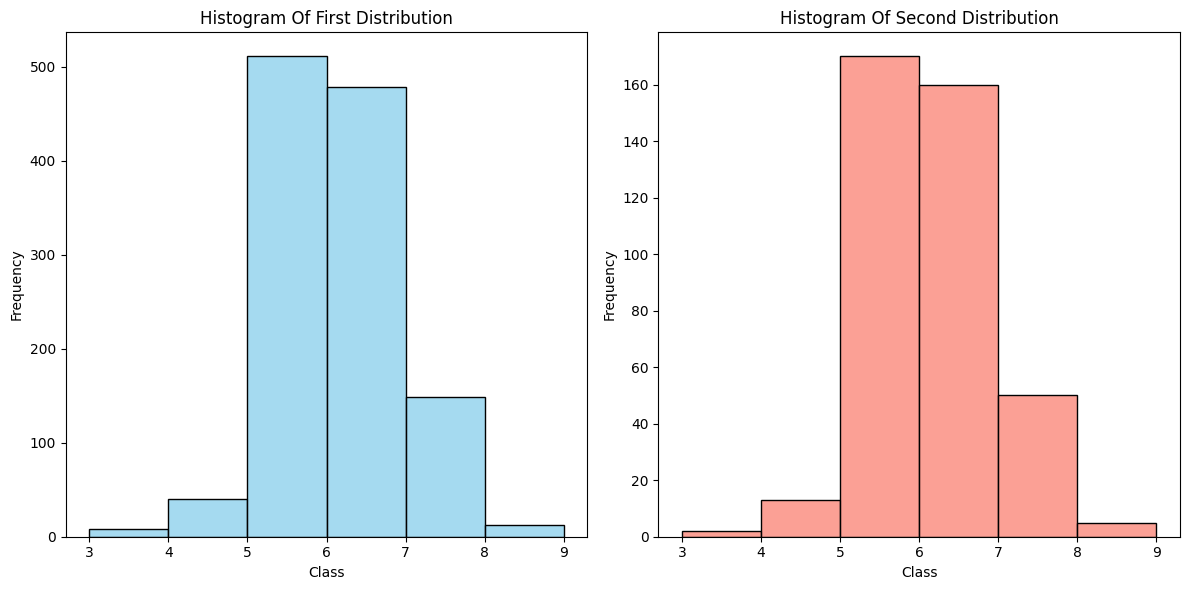

In [38]:
compare_distributions(y_train, y_test)

### This function will help us understand if we improved after each step

In [39]:
def calculate_scores(y_true, y_pred, image_name = None, target_names=['3', '4', '5', '6', '7', '8']):
    report = classification_report(
    y_true, y_pred, target_names=target_names, output_dict=True
    )

    df_report = pd.DataFrame(report).transpose()

    df_report = df_report.drop(columns=['support'], errors='ignore')

    plt.figure(figsize=(10, 6))
    sns.heatmap(
        df_report.iloc[:-1, :].astype(float),
        annot=True, cmap="YlGnBu", cbar=True, fmt=".2f", linewidths=0.5,
    )

    plt.title('Classification Report', fontsize=16, weight='bold')
    plt.xlabel('Metrics', fontsize=14)
    plt.ylabel('Classes', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.tight_layout()

    if image_name:
        plt.savefig(f'./images/{image_name}', dpi=300, bbox_inches='tight')

In [40]:
def calculate_confusion_matrix(y_true, y_pred, image_name=None):

    classes = sorted(set(y_true))

    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap="YlGnBu", xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    if image_name:
     plt.savefig(f'./images/{image_name}', dpi=300, bbox_inches='tight')

## And this function to comapre 2 different classification reports:

In [41]:
def compare_scores(path_result_1, path_result_2, headline_1, headline_2):
    first_pipeline_results = mpimg.imread(path_result_1)
    second_pipeline_results = mpimg.imread(path_result_2)

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].imshow(first_pipeline_results)
    axes[0].axis('off')  # Hide the axes
    axes[0].set_title(headline_1)

    # Display the second image
    axes[1].imshow(second_pipeline_results)
    axes[1].axis('off')  # Hide the axes
    axes[1].set_title(headline_2)

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

# Basic Pipeline:
Let's start with a basic pipline and try some technices to imporve the inital results:

This is a method to round the predictions, we need that to get an actual quality number

In [42]:
def round_results(y_pred):
     # Convert predictions to rounded values
    rounded_values = [round(value) for value in y_pred]

    # Create DataFrame with 'quality' as the header
    df = pd.DataFrame(rounded_values, columns=[target])
    
    return df

Let's train a basic XGB model:

In [43]:
basic_model = XGBRegressor(
    enable_categorical=True,
    max_depth=6,                # Limit tree depth
    learning_rate=0.05,         # Lower learning rate
    n_estimators=500,           # More estimators with small steps
    subsample=0.8,              # Row subsampling
    colsample_bytree=0.8,       # Feature subsampling
    reg_alpha=0.5,              # L1 regularization
    reg_lambda=1,               # L2 regularization
    gamma=1,                    # Prune unnecessary splits
    min_child_weight=5,
    random_state=42         # Minimum leaf weight
)
basic_model.fit(X_train, y_train)
y_pred_reg = basic_model.predict(X_test)
y_pred_over_fiting = basic_model.predict(X_train)
y_pred = round_results(y_pred_reg)
train_mse = mean_squared_error(y_train, y_pred_over_fiting)
test_mse = mean_squared_error(y_test, y_pred)
print(f'Training MSE: {train_mse}')
print(f'Test MSE: {test_mse}')

Training MSE: 0.20281597865398468
Test MSE: 0.415


There exist ofcourse an overfiting, we'll handle it later,

Now let's look at the classification report for the basic pipline

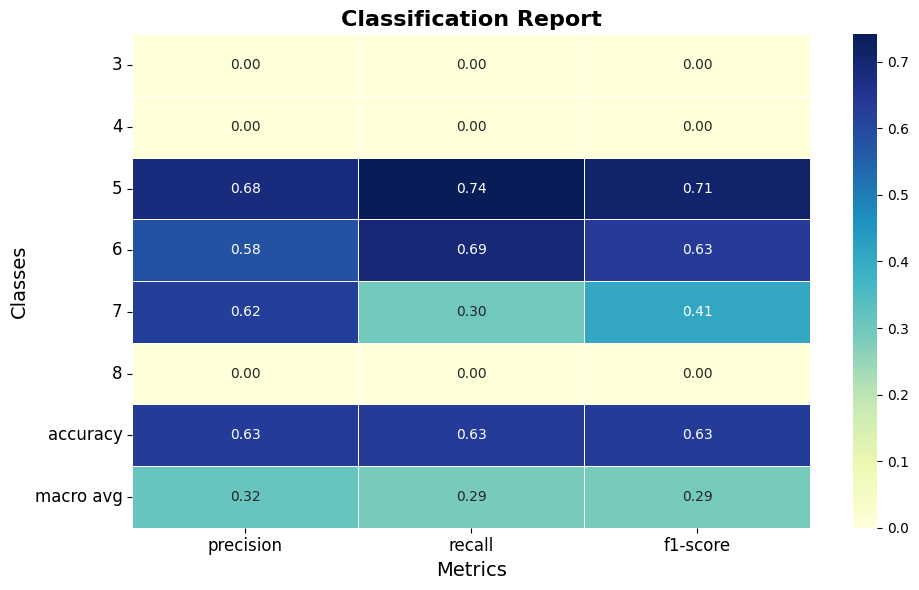

In [44]:
calculate_scores(y_test, y_pred, 'basic-pipline-results')

And a confustion matrix

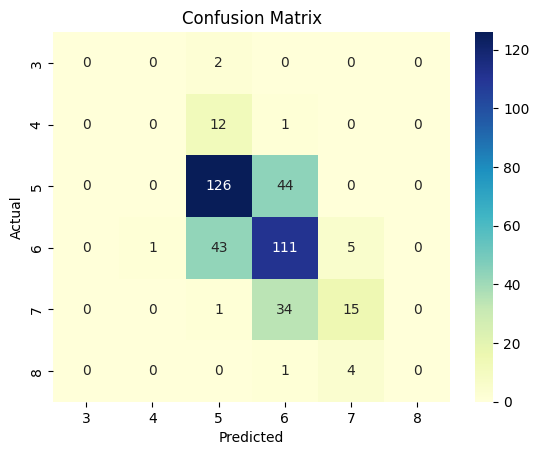

In [45]:
calculate_confusion_matrix(y_test, y_pred)

Lot of mistake on class 3, 4, 8

 Key Takeaways from the Classification Report
## Class Performance:
- **Class 3:**
  - Poor performance with all metrics (`precision`, `recall`, and `f1-score`) being **0**.
  - The model failed to correctly classify any instances of this class.

- **Class 4:**
  - Struggles with low `precision` (**0.60**), `recall` (**0.23**), and `f1-score` (**0.33**).
  - Indicates difficulty in identifying this class correctly.

- **Class 5:**
  - Fairly balanced performance with `precision` (**0.71**), `recall` (**0.71**), and `f1-score` (**0.71**).
  - Shows reasonable performance for this class.

- **Class 6:**
  - Slightly worse `precision` (**0.59**) and `recall` (**0.66**) leading to a `f1-score` (**0.62**).
  - Indicates some imbalance in predictions.

- **Class 7:**
  - Moderate results with `precision` (**0.59**) but lower `recall` (**0.52**), leading to an `f1-score` of **0.55**.

- **Class 8:**
  - Perfect `precision` (**1.00**) but poor `recall` (**0.20**), resulting in a low `f1-score` (**0.33**).
  - Suggests overconfidence with very few true positives.

## Aggregate Metrics:
- **Accuracy:**
  - The overall accuracy is **0.64**, meaning roughly two-thirds of predictions were correct.

- **Macro Average:**
  - `Precision` (**0.58**), `recall` (**0.39**), and `f1-score` (**0.42**) reflect significant disparity in class-wise performance.

## Areas for Improvement:
- Significant attention is needed for **Class 3** and **Class 4**, as their metrics are substantially low.
- **Class 8** demonstrates overconfidence with high `precision` but very low `recall`, suggesting missed true positives.
- Balancing class-wise performance is critical, as shown by the discrepancy between the macro averages and overall accuracy.

## Balanced Classes:
- **Class 5** and **Class 6** exhibit the most balanced performance among the classes, indicating better predictability.

By addressing the weaknesses in specific classes, the overall performance of the classification model can be improved.


Let's try to understand why the predictions upon the edge clssses fail so badly
If the problem is the sample amount, then if we will undersample to majorty classes will get bad results for them as well.

In [46]:
rus = RandomUnderSampler(random_state=42)
X_train_undersampled, y_train_undersampled = rus.fit_resample(X_train, y_train)

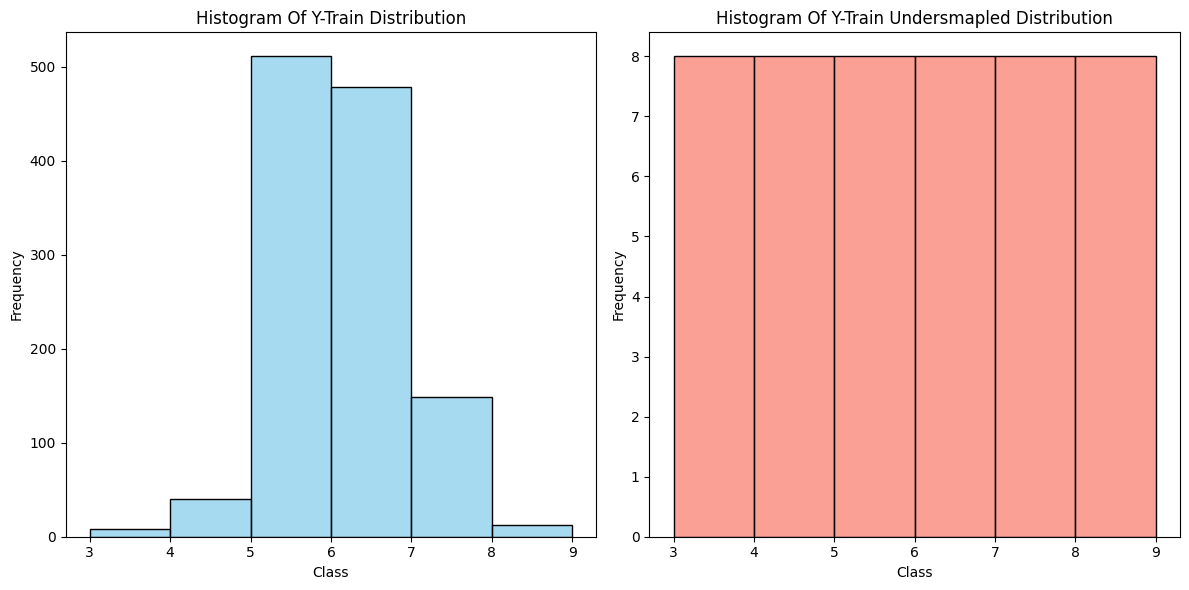

In [47]:
compare_distributions(y_train, y_train_undersampled, y1_name='Y-Train Distribution', y2_name='Y-Train Undersmapled Distribution')

We can see we undersampled all the classes to around 8 samples each, let's see what's the basic model manage to learn:

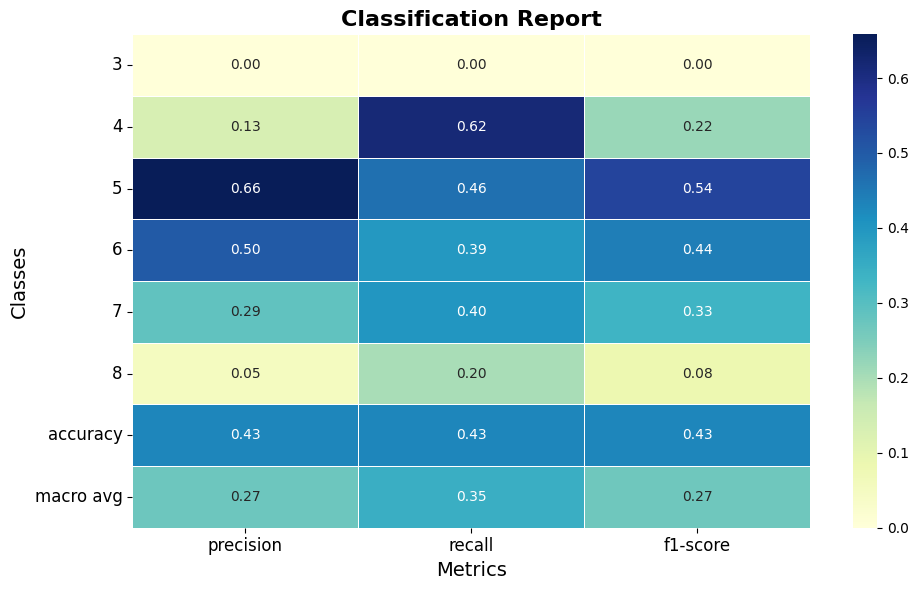

In [48]:
basic_model.fit(X_train_undersampled, y_train_undersampled)
y_pred_undersampled = round_results(basic_model.predict(X_test))
calculate_scores(y_true = y_test, y_pred = y_pred_undersampled, image_name='basic-model-undersampled')


That's kinda weird, we have the same sample size for each class and still, the minorty classes from before have the worst results.

Let's look at the confusion matrix and see why and where the model goes wrong for those classes:

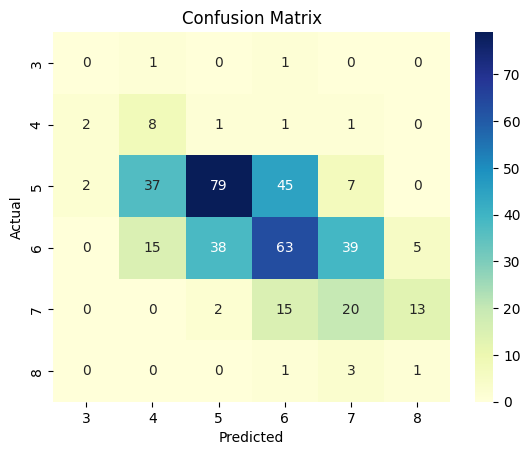

In [49]:
calculate_confusion_matrix(y_true = y_test, y_pred = y_pred_undersampled)

We see that there are really tiny amount of wines with quality 8 and 3 to test, 
And because of that, every mistake there really lower the score.
Which means that this score doesn't really reflect what the model learned about those classes.

Let's try to undersample the majortity classes on the __test__ data set as well, and then see if the results turn out to be bad there as well:

In [50]:
X_test_undersampled, y_test_undersampled = rus.fit_resample(X_test, y_test)

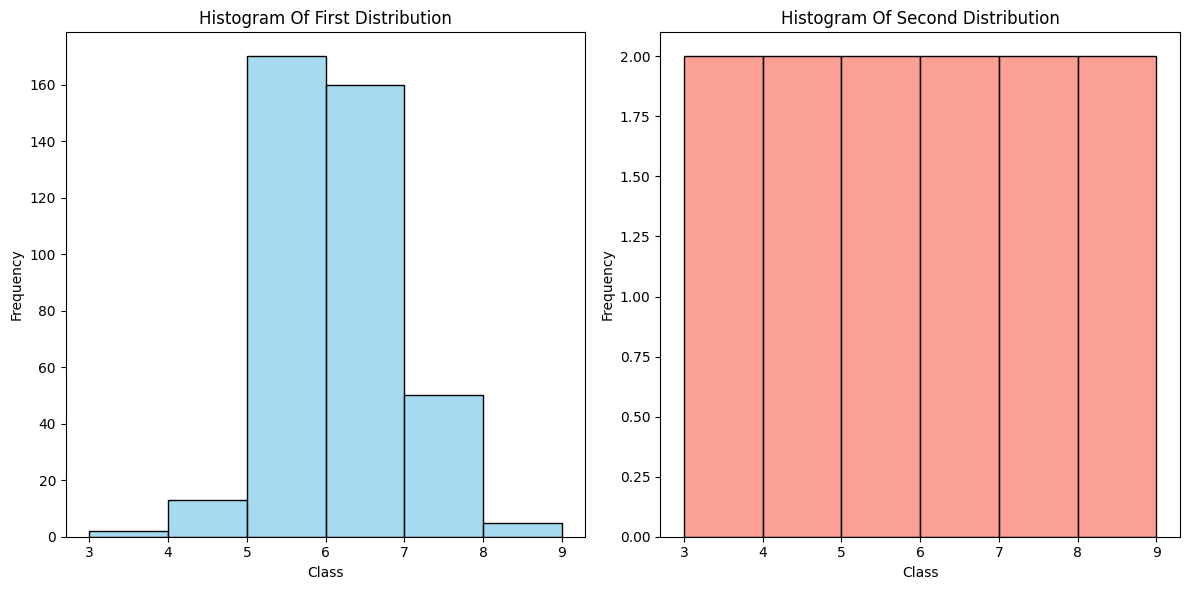

In [51]:
compare_distributions(y_test, y_test_undersampled)

Now let's see if there still exitst some kind of a biased towrads the middle classes:

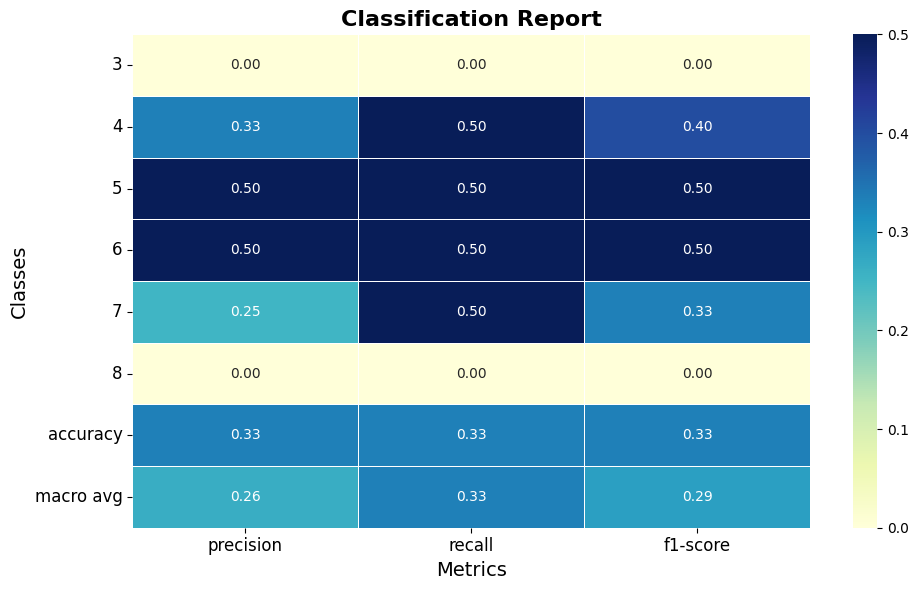

In [52]:
y_pred_undersapmled = round_results(basic_model.predict(X_test_undersampled))
calculate_scores(y_test_undersampled, y_pred_undersapmled)

And a confusion matrix:

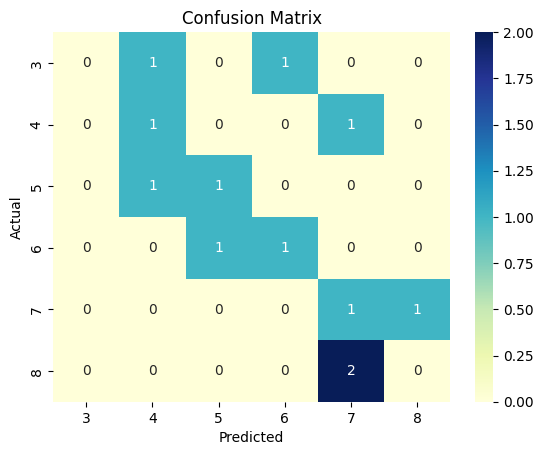

In [53]:
calculate_confusion_matrix(y_true = y_test_undersampled, y_pred = y_pred_undersapmled)

It might be randomic but it's quite weird for us that just the "edge" classes didn't get any prediction right.
There is no excuse for that now, the train samples amount and test samples amount are equals for each class.
Any way, I think we came to an understanding that the samples amount on extreme classes for the test classes are too small for us to infer realaistic insights.
It's also so small that it's not possible to use some oversampling method to generate more data for them.
We __need__ to get more data for the minority classes.


We __need__ to get more data for the minority classes.
With that, let us indrouduce the winequality-white data set that contains qualities of white wines.

In [54]:
dfw = pd.read_csv('./data/winequality-white.csv', sep=';')
dfr = pd.read_csv('./data/winequality-red.csv', sep=';')
target = 'quality'

In [55]:
dfw['wine_type'] = 0
dfr['wine_type'] = 1
dfc = pd.concat([dfw, dfr], ignore_index=True)


In [56]:
X = dfc.drop(columns = [target])
y = dfc[target]

<Axes: >

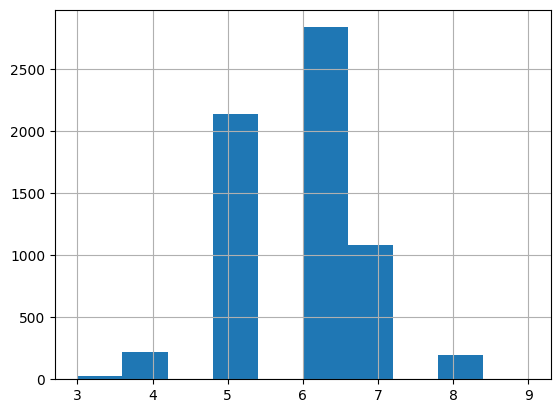

In [57]:
y.hist()

remove the 9th quality

In [58]:
X = X[y != 9].reset_index(drop=True)
y = y[y != 9].reset_index(drop=True)


<Axes: >

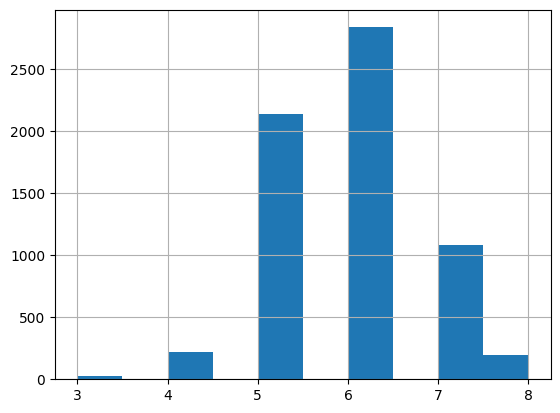

In [59]:
y.hist()

In [60]:
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

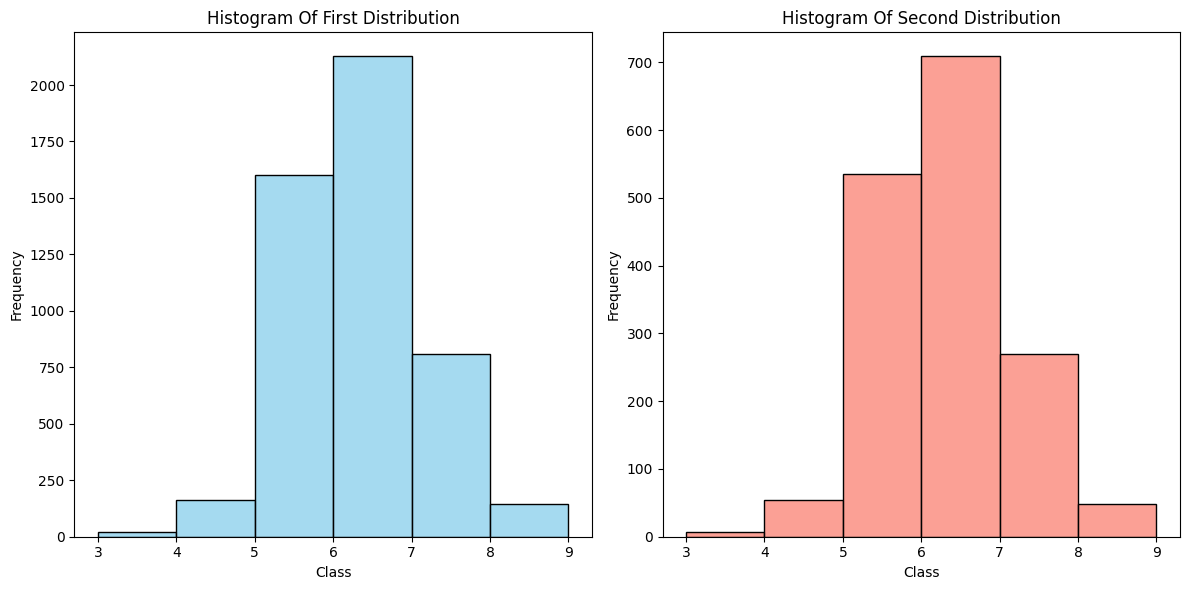

In [61]:
compare_distributions(y_train, y_test)

We can see that there is still a huge imbalnce in the data.
Class 3 has aorund 20 values while class 6 has over 2000 samples.
We'll relate it later, 
right now let's try to see what the basic pipline gives us.

In [71]:
xgboost_basic_model = XGBRegressor(
    enable_categorical=True,
    max_depth=6,                # Limit tree depth
    learning_rate=0.05,         # Lower learning rate
    n_estimators=500,           # More estimators with small steps
    subsample=0.8,              # Row subsampling
    colsample_bytree=0.8,       # Feature subsampling
    reg_alpha=0.5,              # L1 regularization
    reg_lambda=1,               # L2 regularization
    gamma=1,                    # Prune unnecessary splits
    min_child_weight=5,
    random_state=42         # Minimum leaf weight
)

In [72]:
xgboost_basic_model.fit(X_train, y_train)
y_pred = round_results(xgboost_basic_model.predict(X_test))

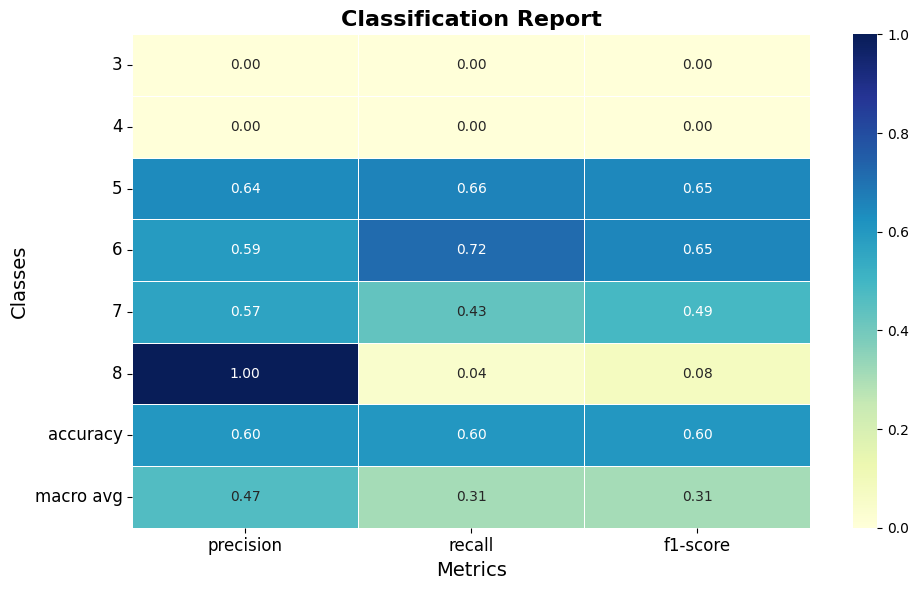

In [74]:
calculate_scores(y_true=y_test, y_pred=y_pred, image_name='basic-pipline-full-data-results')

And let's watch the confusion matrix to gain more results:

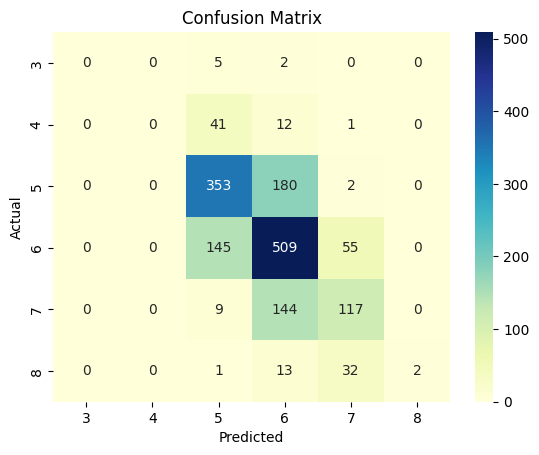

In [75]:
calculate_confusion_matrix(y_true=y_test, y_pred=y_pred)

to do: add conclusions:

As expectede the results has some sort of bias towards the middle becasue of the imbalance.

Let's try to solve it by using smote, later the score gaps will have an actuall reason that is not a model bias:

to do: add explnation about smote.

In [79]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

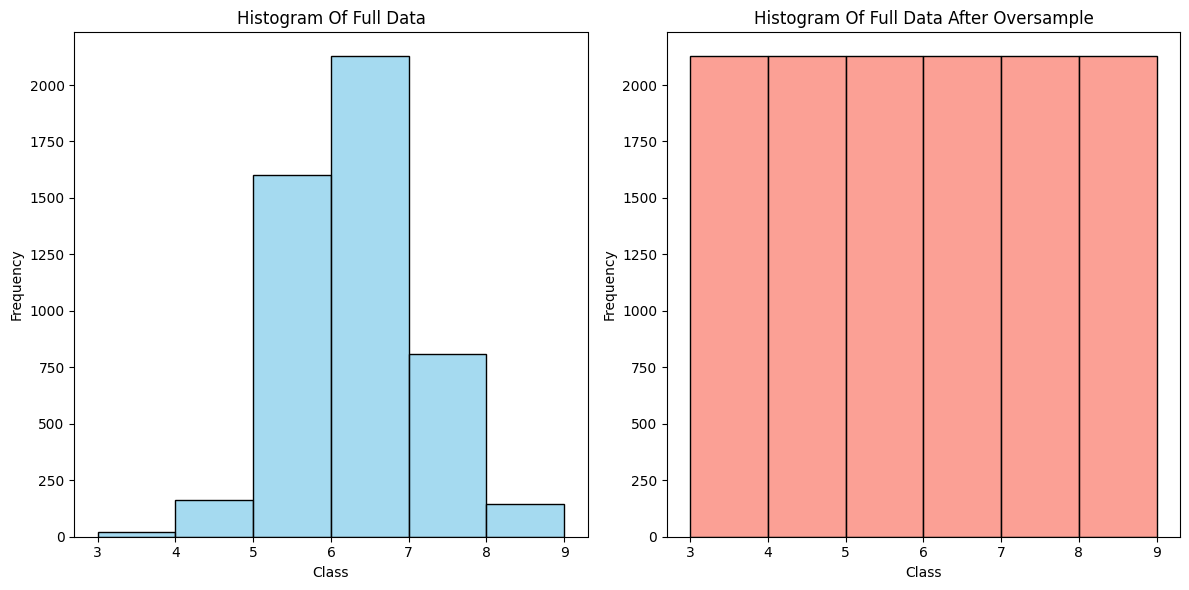

In [83]:
compare_distributions(y_train, y_train_smote, y1_name='Full Data', y2_name='Full Data After Oversample')

Let's train the model again and watch the results:

In [84]:
xgboost_basic_model.fit(X_train_smote, y_train_smote)
y_pred = round_results(xgboost_basic_model.predict(X_test))

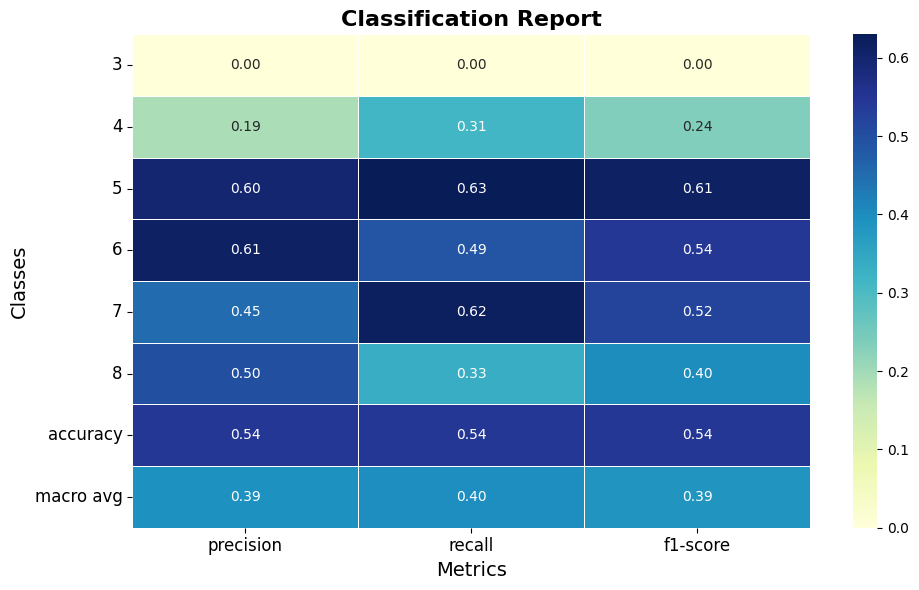

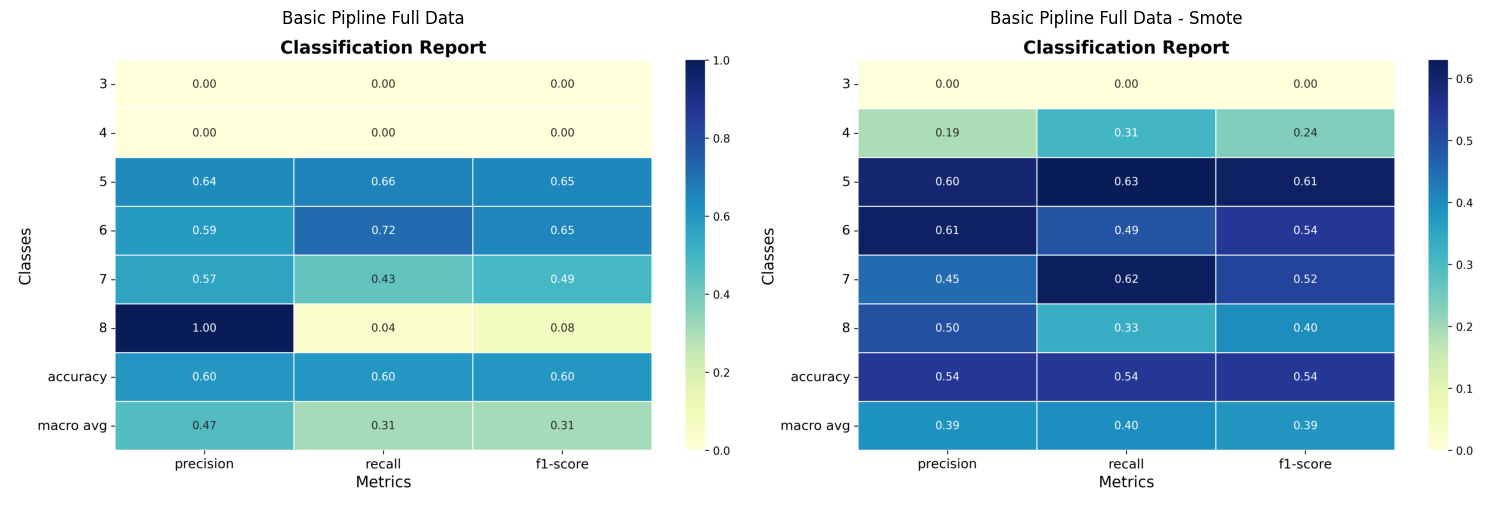

In [85]:
calculate_scores(y_true=y_test, y_pred=y_pred, image_name='basic-pipline-full-data-smote-results')
compare_scores(path_result_1='./images/basic-pipline-full-data-results.png',
               path_result_2='./images/basic-pipline-full-data-smote-results.png',
                headline_1='Basic Pipline Full Data',
                headline_2='Basic Pipline Full Data - Smote')

Also let's watch the confusion matrix:

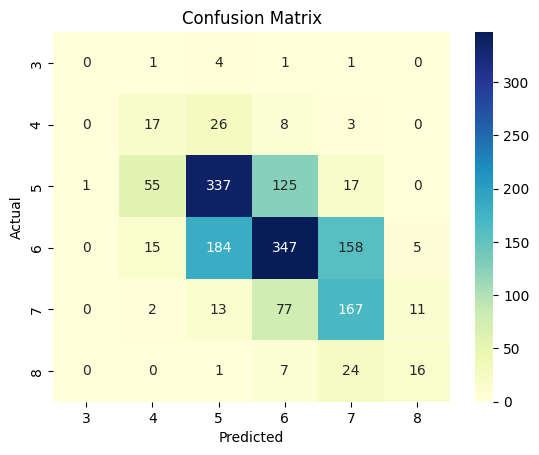

In [82]:
calculate_confusion_matrix(y_true=y_test, y_pred=y_pred)

to do: add insights:

### Error Analysis + Feature Engeneering

Let us indtrouduce 2 method to evaluate feature performance on 

In [91]:
def plot_importance(model):
    importances_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': basic_model.feature_importances_
    }).sort_values('Importance', ascending=False)

    sns.set_style("whitegrid")
    sns.set_context("talk")
    sns.barplot(
        data=importances_df,
        x='Importance',
        y='Feature',
        palette='Blues_d',
    )
    plt.tight_layout()

    plt.show()


In [92]:
def plot_shap_values_by_classes(shap_values, X_test, y_test, classes_numbers=[3,4,5,6,7,8]):
    plt.figure(figsize=(40, 30))
    for idx, i in enumerate(classes_numbers):
        ax = plt.subplot(3, 2, idx + 1)  # Create subplot
        shap.summary_plot(
        shap_values[y_test == i],
        X_test[y_test == i],
        show=False,
        plot_size=(15, 18),
        )
        ax.set_title(f"SHAP Summary - Quality {i}", fontsize=16)
    # Adjust the layout and display the plots
    plt.tight_layout(pad=3.0)
    plt.show()

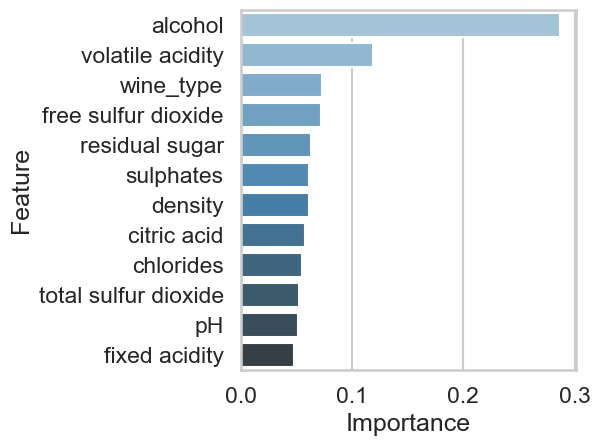

In [95]:
plot_importance(xgboost_basic_model)

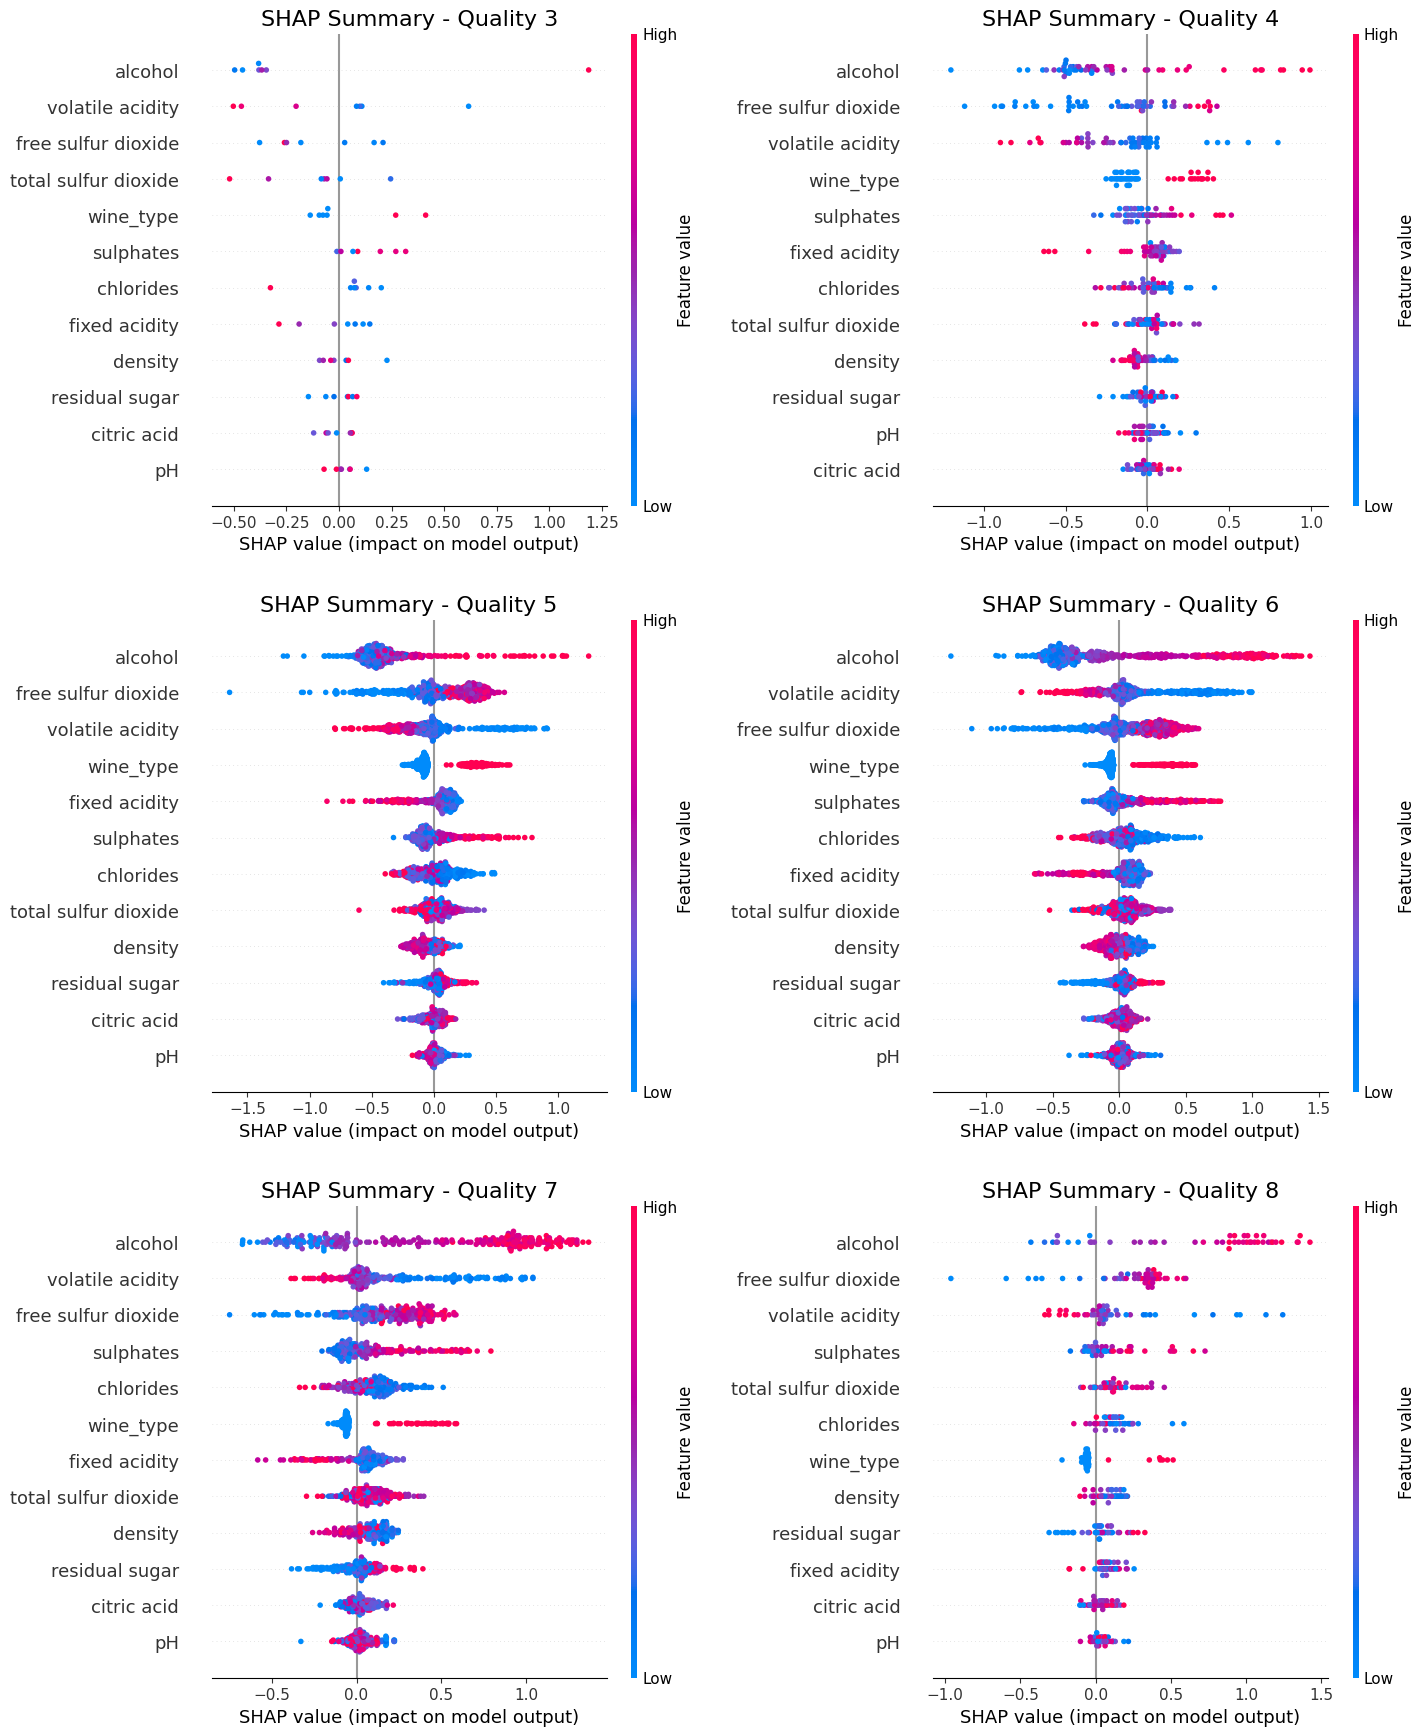

In [94]:
explainer = shap.TreeExplainer(xgboost_basic_model)
shap_values = explainer.shap_values(X_test, y_pred)
plot_shap_values_by_classes(shap_values, X_test, y_test)

### Hyper Parameters Tuning

to do: explain about optuna

In [87]:
def objective(trial):
    # Define the parameter space
    params = {
        "objective": "reg:squarederror",
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0.01, 0.1, log=True),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.001, 1.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1.0, 5.0, log=True),
    }

    # Train the model with the given parameters
    model = XGBRegressor(**params, random_state=42)
    
    # Use cross-validation to evaluate the model
    cv_scores = cross_val_score(model, X_train_smote, y_train_smote, cv=5, scoring="neg_mean_squared_error")
    mean_cv_score = -cv_scores.mean()  # Convert negative MSE to positive

    return mean_cv_score  # Optuna minimizes the objective function

# Step 3: Create the Optuna Study
study = optuna.create_study(direction="minimize")  # We aim to minimize the MSE
study.optimize(objective, n_trials=50, timeout=3600)  # 50 trials or 1-hour limit

# Step 4: Retrieve the Best Parameters
print("Best Parameters:", study.best_params)
print("Best MSE (CV):", study.best_value)

# Step 5: Train the Final Model with the Best Parameters
best_model = XGBRegressor(**study.best_params, random_state=42)


[I 2025-01-24 02:27:57,529] A new study created in memory with name: no-name-29bbe20e-eabc-4bcd-abf7-a729209a71f4


[I 2025-01-24 02:28:03,915] Trial 0 finished with value: 0.5167106402336888 and parameters: {'learning_rate': 0.06422896878647529, 'max_depth': 9, 'n_estimators': 449, 'subsample': 0.7043953723866353, 'colsample_bytree': 0.9598403866220611, 'gamma': 0.010982111972317608, 'min_child_weight': 10, 'reg_alpha': 0.031151430998990783, 'reg_lambda': 3.0746090822738625}. Best is trial 0 with value: 0.5167106402336888.
[I 2025-01-24 02:28:09,155] Trial 1 finished with value: 0.5790897514878447 and parameters: {'learning_rate': 0.07477004137491819, 'max_depth': 7, 'n_estimators': 486, 'subsample': 0.9070735459473054, 'colsample_bytree': 0.9882258695734534, 'gamma': 0.02374553346740142, 'min_child_weight': 1, 'reg_alpha': 0.2991529241035888, 'reg_lambda': 2.3376309574974266}. Best is trial 0 with value: 0.5167106402336888.
[I 2025-01-24 02:28:10,901] Trial 2 finished with value: 0.6991086860935803 and parameters: {'learning_rate': 0.055405826533974224, 'max_depth': 8, 'n_estimators': 149, 'subsam

Best Parameters: {'learning_rate': 0.08688633573236695, 'max_depth': 10, 'n_estimators': 458, 'subsample': 0.7262042342381607, 'colsample_bytree': 0.9834605902032972, 'gamma': 0.011090236073645182, 'min_child_weight': 10, 'reg_alpha': 0.039184355296675896, 'reg_lambda': 4.608904986796045}
Best MSE (CV): 0.49663939661171935


In [88]:
best_model.fit(X_train_smote, y_train_smote)
y_pred = round_results(best_model.predict(X_test))

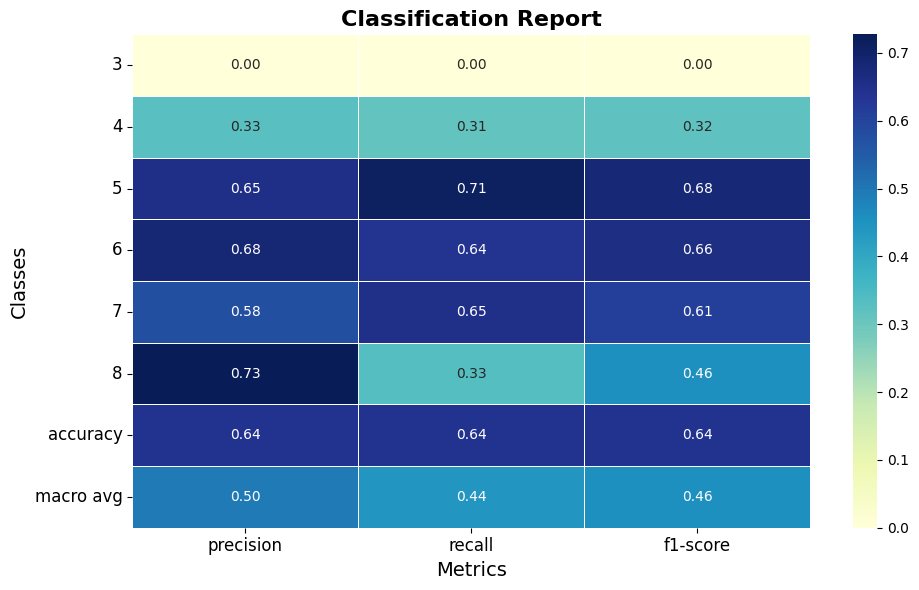

In [89]:
calculate_scores(y_true=y_test,y_pred=y_pred, image_name='best-pipline-full-data-results')

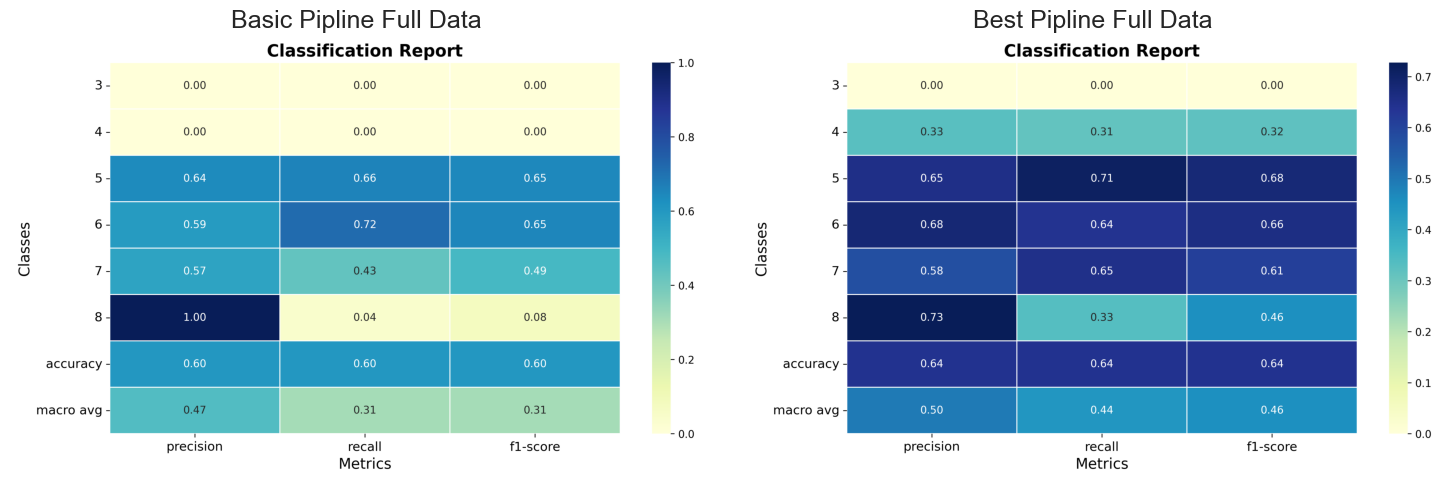

In [96]:
compare_scores(path_result_1='./images/basic-pipline-full-data-results.png',
               path_result_2='./images/best-pipline-Full-data-results.png',
                headline_1='Basic Pipline Full Data',
                headline_2='Best Pipline Full Data')

And let's view the final model's feaures importance:

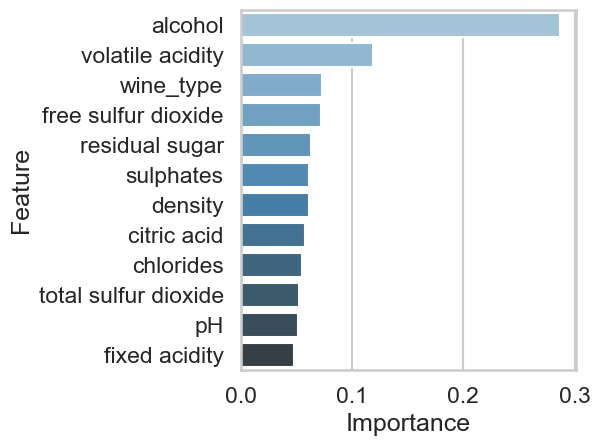

In [97]:
plot_importance(best_model)

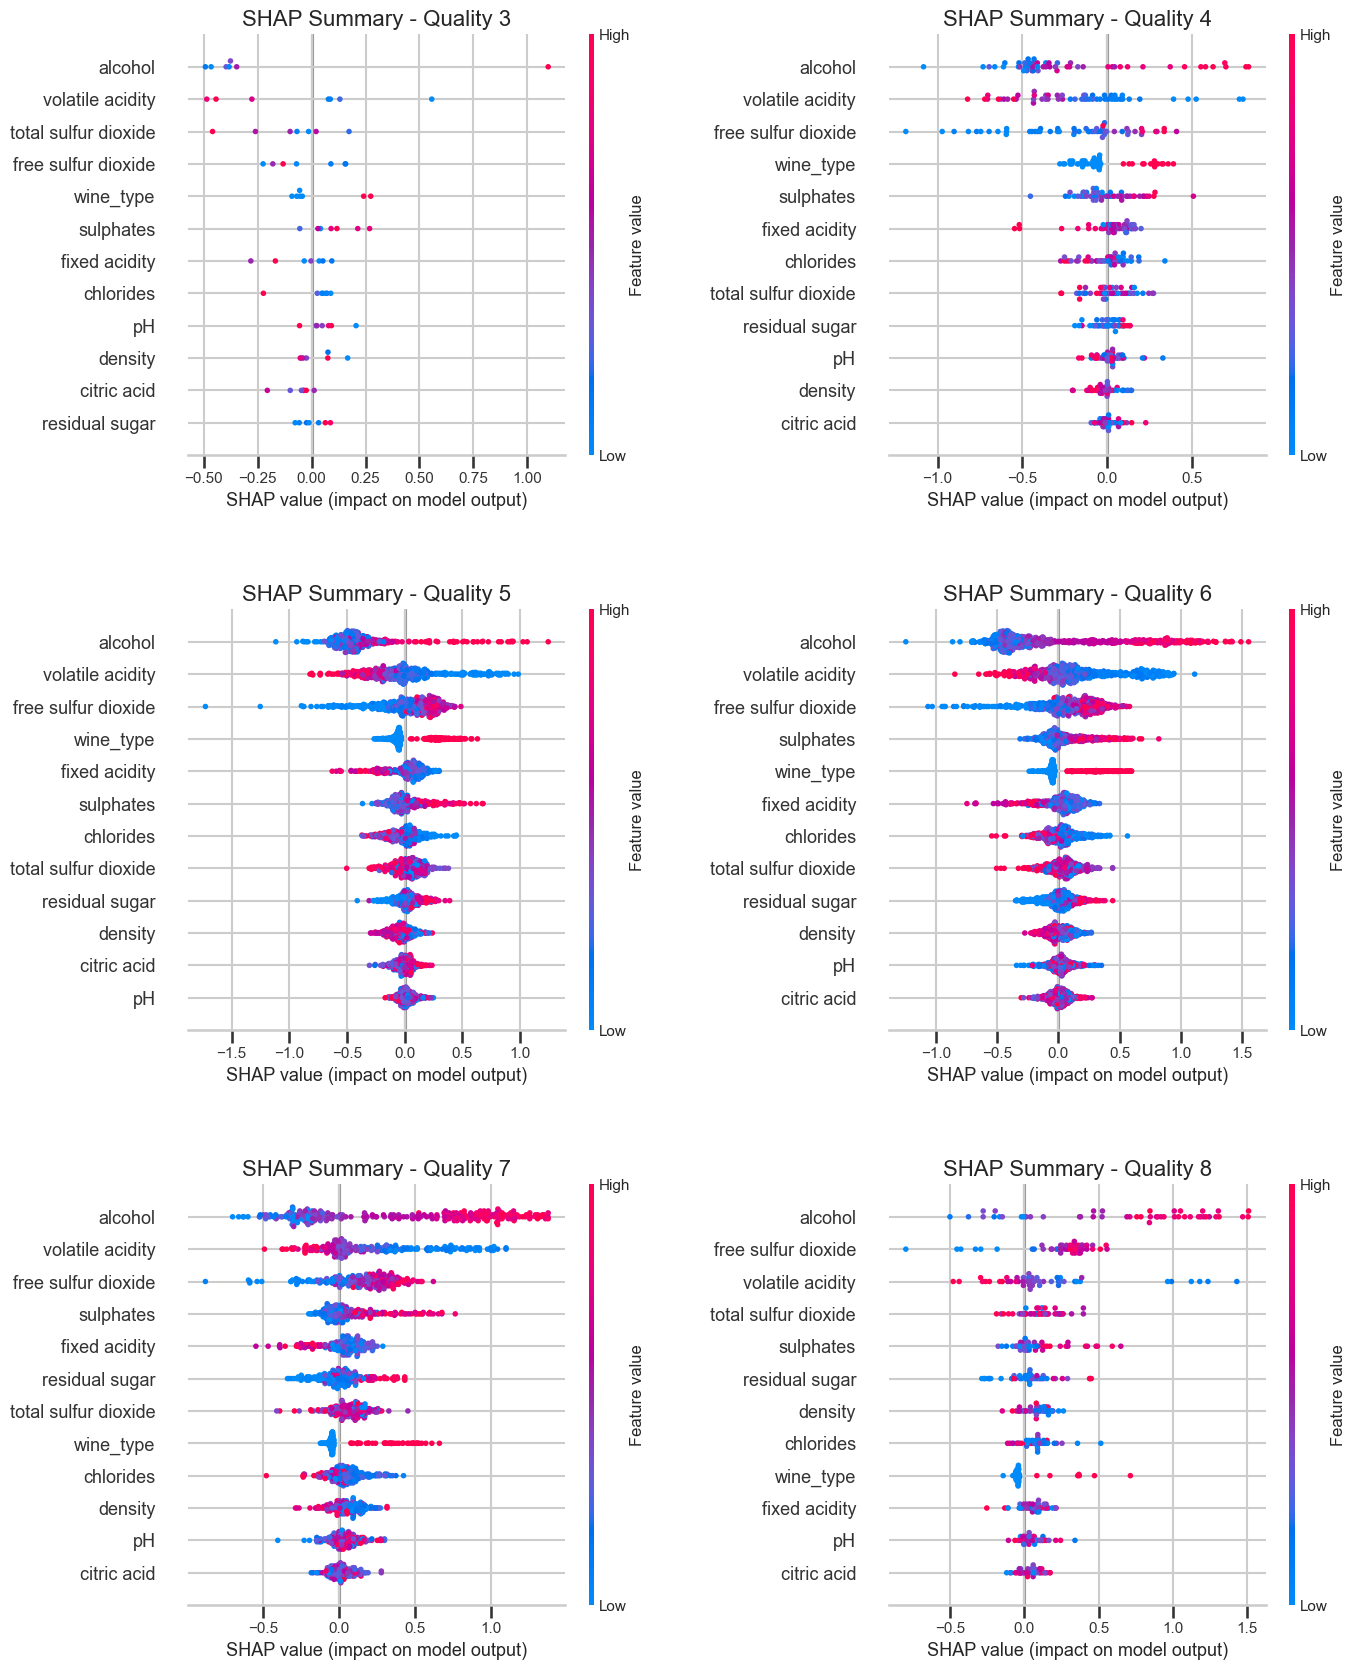

In [99]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test, y_pred)
plot_shap_values_by_classes(shap_values, X_test, y_test)

to do: update insights

**Key Takeaways from the SHAP Analysis by Wine Quality Class**

- **Overall Common Drivers**
  - **Volatile Acidity** and **Alcohol (and Alcohol Density)** repeatedly appear among the most influential predictors across different quality levels.
  - **Sulphates** is another frequent top contributor. Generally, higher sulphates seem to push predictions toward higher quality.
  - **Total Sulfur Dioxide** and **Free Sulfur Dioxide** also appear crucial but with differing directions (positive/negative) depending on the quality level.

---

### Quality 3
- **Volatile Acidity** is highly influential: high values often contribute strongly to lowering quality predictions (negative SHAP).
- **Chlorides** and **Total Sulfur Dioxide** also have sizable impact.
- **Alcohol** and **pH** appear mid-level in importance: higher alcohol can nudge predictions up, whereas high pH can be either positive or negative depending on the rest of the features.

### Quality 4
- **Volatile Acidity** again takes the top spot; typically, higher volatile acidity lowers quality.
- **Sulphates** and **Alcohol** both play strong positive roles in raising predicted quality when at higher levels.
- **pH** and **Ideal pH** also feature prominently, often with mixed influence depending on whether the wine is above or below an optimal range.

### Quality 5
- **Alcohol Density** and **Alcohol** appear as leading contributors, often pushing predictions up if above certain thresholds.
- **Sulphates** continues to be strongly correlated with higher quality.
- **Volatile Acidity** is still important; high volatile acidity can pull the quality down.
- **Total Sulfur Dioxide** and **Percent Free Sulfur** are noticeable contributors, though their directions vary by sample.

### Quality 6
- **Volatile Acidity** remains high-impact and typically negative for quality.
- **pH** and **Alcohol** are crucial; moderate/higher alcohol values tend to improve quality predictions.
- **Sulphates** is again near the top, indicating higher sulphates generally support better quality.
- **Residual Sugar** and **Alcohol Density** also show up with noticeable effect sizes.

### Quality 7
- **Alcohol Density**, **Sulphates**, and **Volatile Acidity** are the top three here as well.
- **Percent Free Sulfur** and **Free Sulfur Dioxide** factor prominently; moderate levels seem beneficial, but extremes can reduce quality.
- **pH** remains important, and high **Fixed Acidity** can sometimes be detrimental (negative SHAP values).

### Quality 8
- **Sulphates** and **Alcohol** dominate the top influences for higher quality predictions.
- **Chlorides** and **Volatile Acidity** are also critical; high chlorides or high volatile acidity typically push the prediction down.
- **pH**, **Citric Acid**, and **Total/Free Sulfur Dioxide** maintain influence, though their effects can shift from positive to negative depending on exact value ranges.

---

**Cross-Quality Observations**
- **Volatile Acidity** consistently shows a strong negative association with higher quality levels.
- **Sulphates**, **Alcohol**, and **Alcohol Density** more often have a positive impact on the predicted quality—especially noticeable as you move into higher-quality ranges (7–8).
- **Sulfur Dioxide (Total and Free)** has a nuanced effect: moderate levels might be beneficial for certain qualities, whereas too high or too low levels can hurt the prediction.
- **pH** and **Ideal pH** matter across multiple qualities, highlighting the importance of balancing acidity.

volatile acidity, sulphates, and alcohol-related features are consistently impactful across the spectrum of wine quality.


# References:

ChatGPT was used for:
1. Improving readability of all comments
2. Improving the plots
3. Explaining SHAP

https://xgboost.readthedocs.io/en/latest/python/python_api.html
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
https://www.kaggle.com/code/shilongzhuang/s3e5-complete-feature-engineering-guide


from here it's the try to solve it for easier task.

<Axes: >

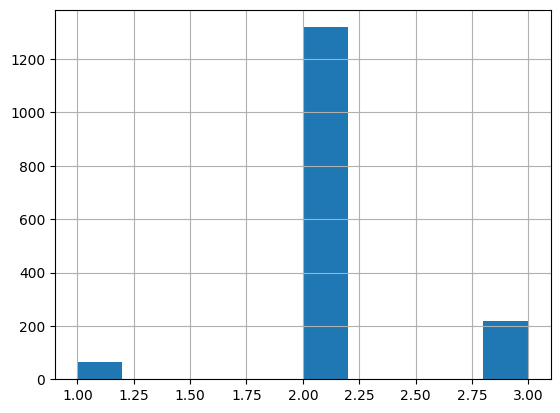

In [36]:
y_e.hist()

Now let's split again and let's try to learn upon this model:

In [98]:
X_e_train, X_e_test, y_e_train, y_e_test = split_data_set(X_e,y_e)

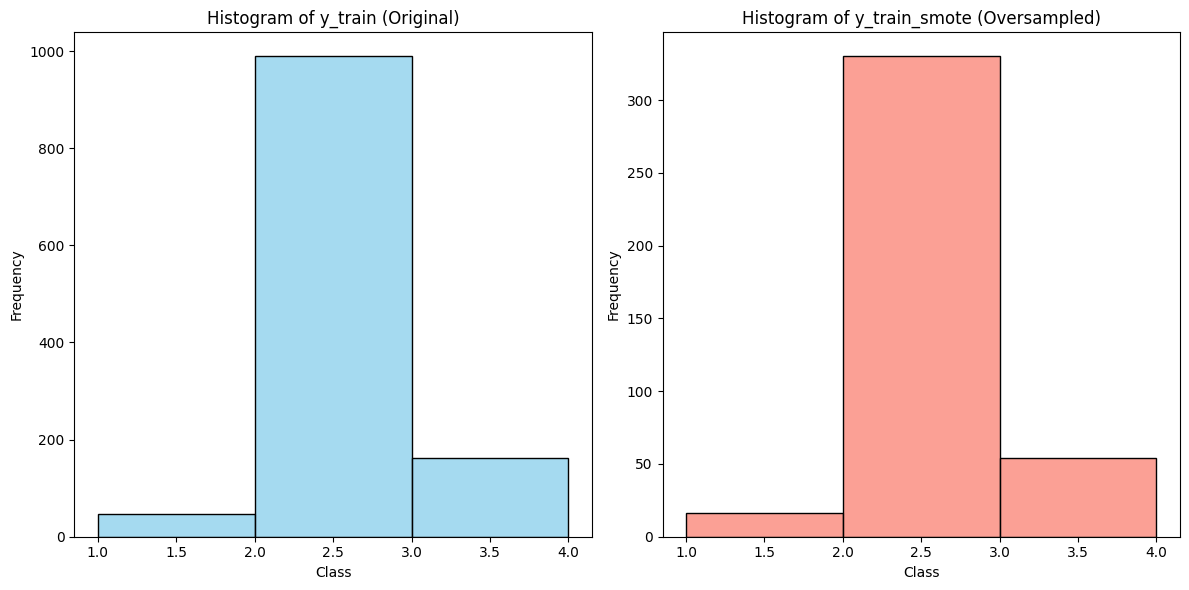

In [39]:
compare_distributions(y_e_train, y_e_test)

In [138]:
basic_model.fit(X_e_train, y_e_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [143]:
y_e_pred = round_results(basic_model.predict(X_e_test))

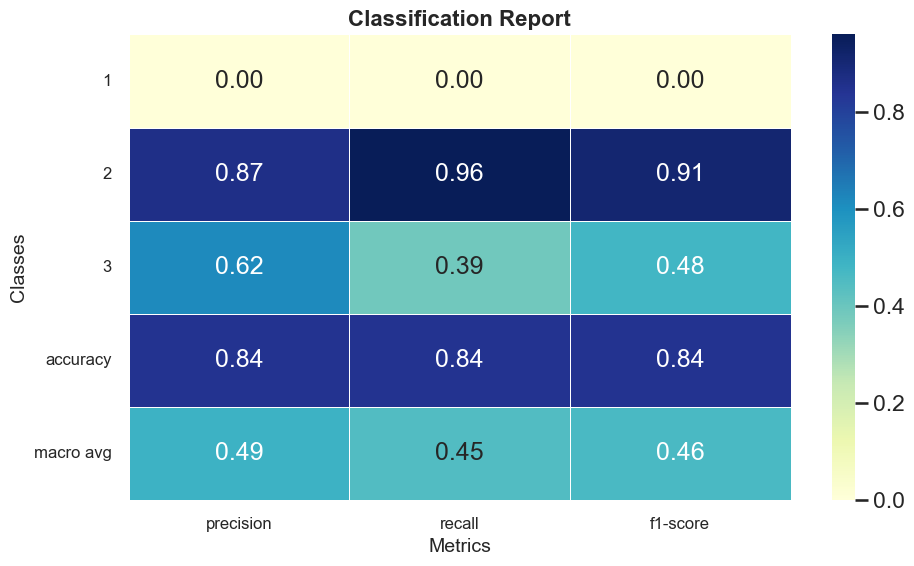

In [144]:
calculate_scores(y_true=y_e_test, y_pred=y_e_pred_rounded, target_names = ['1', '2', '3'])

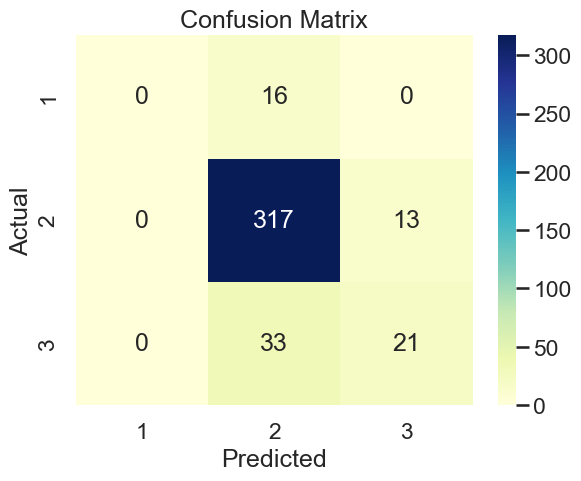

In [145]:
calculate_confusion_matrix(y_true=y_e_test, y_pred=y_e_pred_rounded)

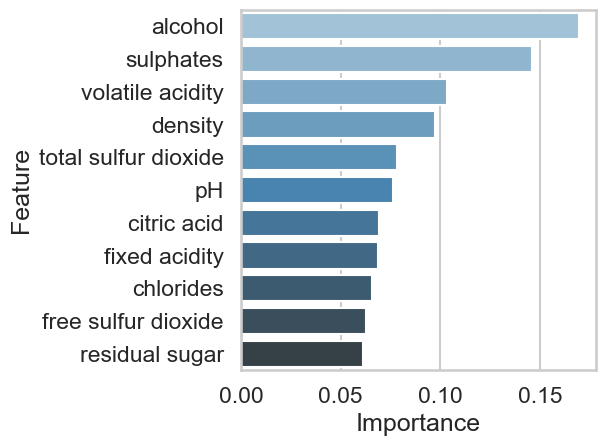

In [146]:
plot_importance(basic_model)

In [147]:
explainer = shap.TreeExplainer(basic_model)
shap_values_e = explainer.shap_values(X_e_test, y_e_test)

AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

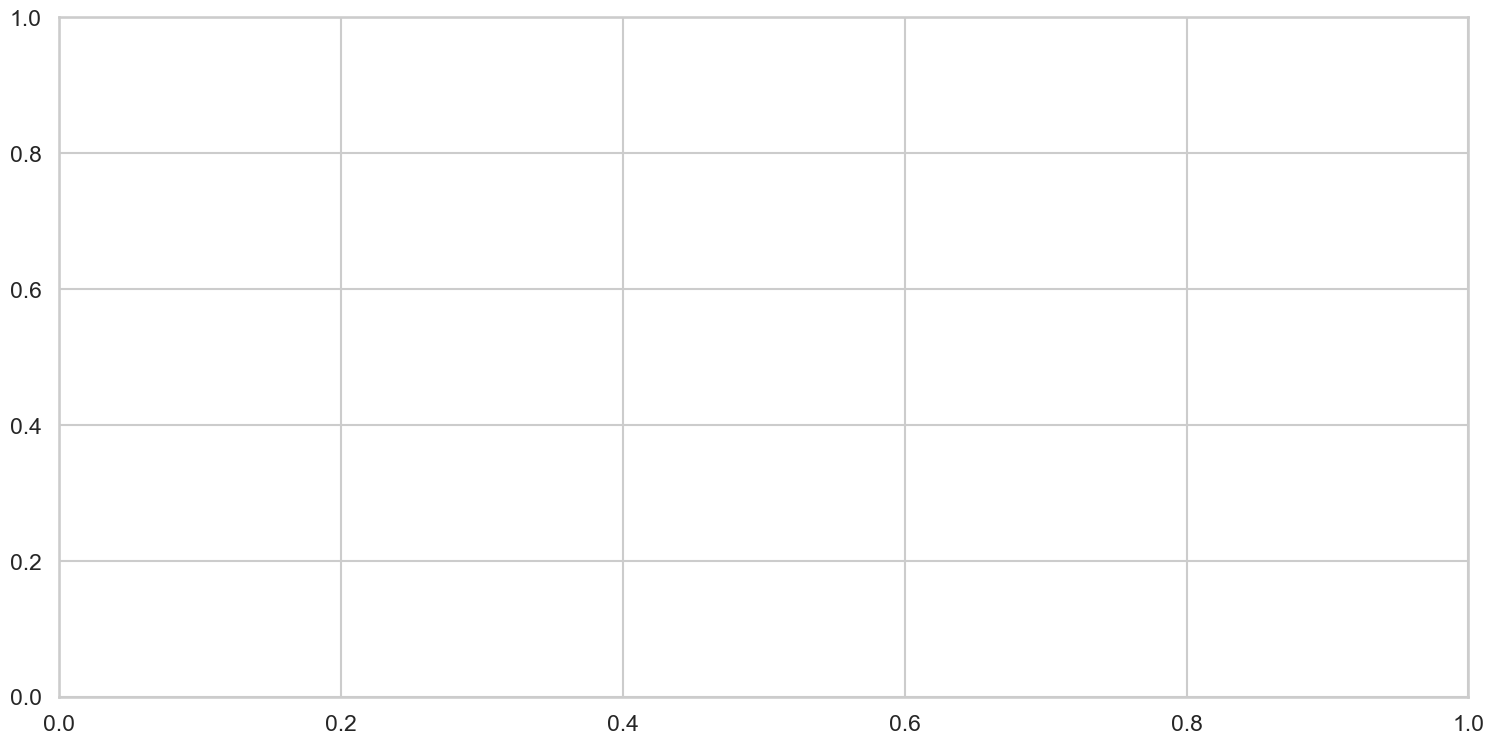

In [284]:
plot_shap_values_by_classes(shap_values_e, X_test=X_e_test, y_test=y_e_test, classes_numbers=[1,2,3])

I think we should remove some non interesting features, (to do: add maybe correlation matrix or plot from the eda)

In [155]:
X_e_test.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol'],
      dtype='object')

In [275]:
removed_features = ['pH', 'fixed acidity', 'residual sugar', 'free sulfur dioxide']

In [276]:
X_f_test = X_e_test.drop(columns=removed_features)
X_f_train = X_e_train.drop(columns=removed_features)
y_f_test = y_e_test
y_f_train = y_e_train

In [277]:
basic_model.fit(X_f_train, y_f_train)
y_f_pred = round_results(basic_model.predict(X_f_test))


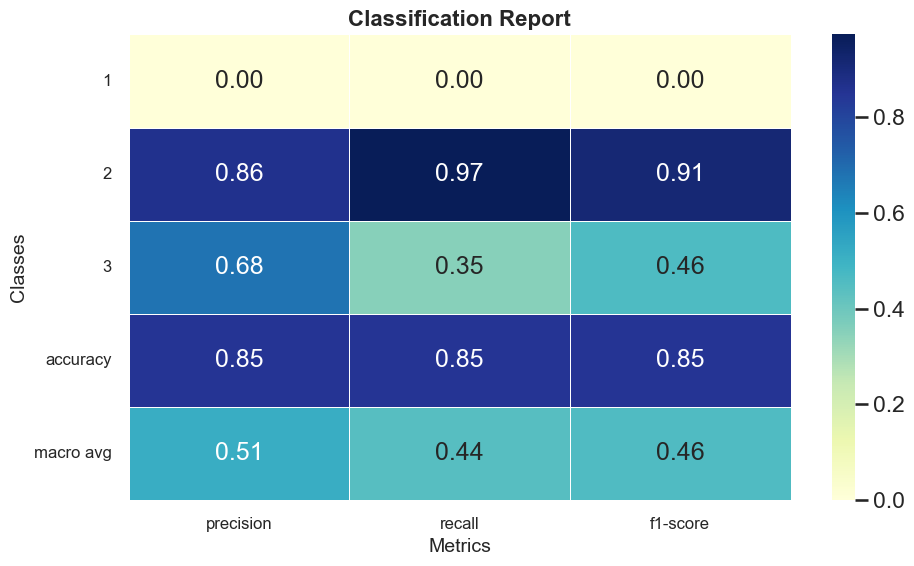

In [278]:
calculate_scores(y_true=y_f_test, y_pred=y_f_pred, target_names = ['1', '2', '3'])

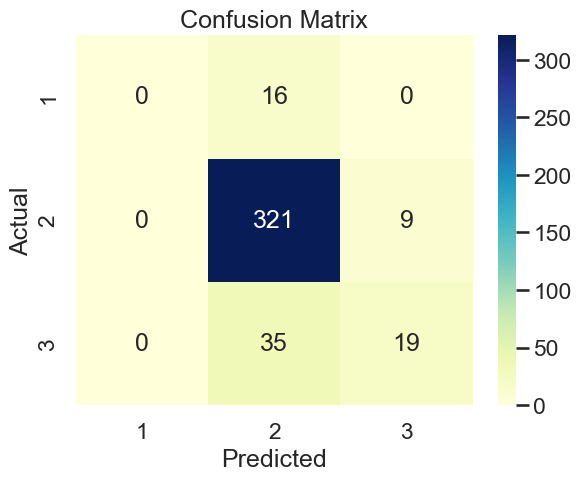

In [279]:
calculate_confusion_matrix(y_true=y_f_test, y_pred=y_f_pred)

In [281]:
explainer = shap.TreeExplainer(basic_model)
shap_values_f = explainer.shap_values(X_f_test, y_f_test)

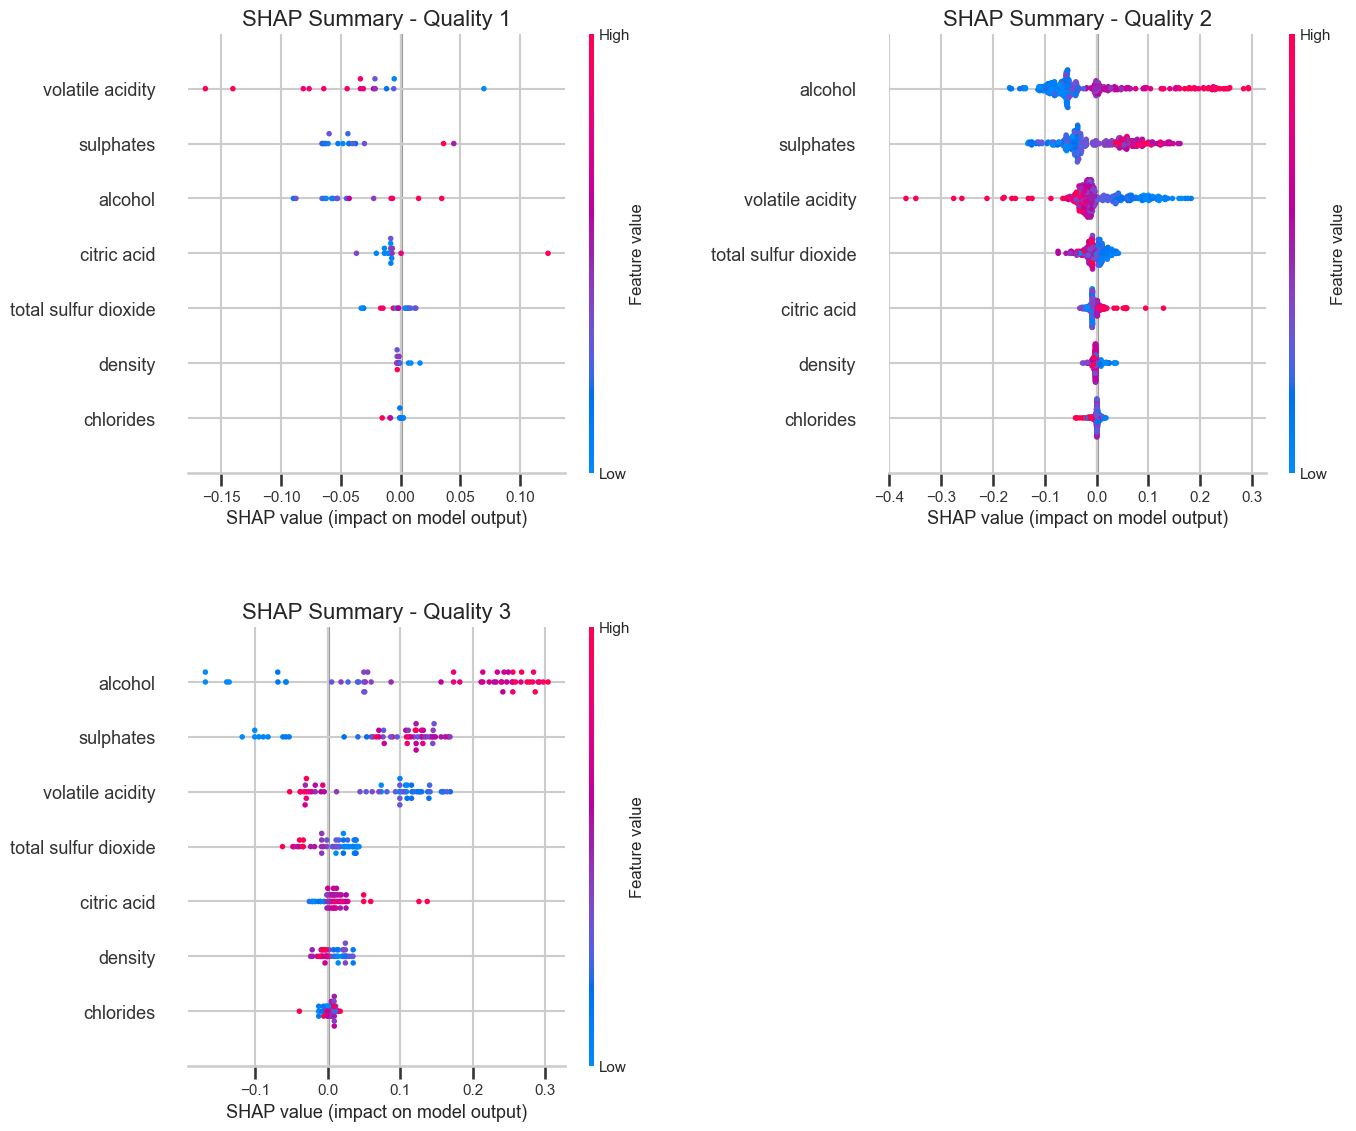

In [285]:
plot_shap_values_by_classes(shap_values_f, X_test=X_f_test, y_test=y_f_test, classes_numbers=[1,2,3])

I want to check if the mistakes on class 3 has some sort of correlation with ignoring critic acid:

In [290]:
shap_values_class_3 = shap_values_f[y_f_test == 3]
shap_values_class_3

array([[ 9.95986238e-02,  8.14335234e-03,  9.26803425e-03,
        -8.08120798e-03,  2.45658159e-02,  1.22111335e-01,
         5.00446670e-02],
       [-2.91444175e-02, -9.50251520e-03, -6.45222259e-04,
        -3.42401005e-02,  1.46469520e-02,  1.32012084e-01,
         2.78702766e-01],
       [-6.56734686e-03, -4.17204341e-03,  1.22657896e-03,
        -3.88726406e-02,  1.49484864e-02,  1.09792329e-01,
         2.59133190e-01],
       [ 1.41351417e-01,  2.54390910e-02,  2.05331878e-03,
         4.04953659e-02,  3.50925736e-02,  1.45019427e-01,
         2.40246728e-01],
       [ 1.09651573e-01,  5.76592330e-03,  2.93783355e-03,
         1.59489606e-02, -7.10451836e-03,  6.71148002e-02,
        -1.39016166e-01],
       [ 9.97559056e-02, -7.48221995e-04,  4.38758783e-04,
        -4.78121154e-02, -3.07246787e-03,  7.81219229e-02,
        -6.86377659e-02],
       [ 1.15688704e-01,  4.97786216e-02, -1.21245394e-02,
        -3.34443115e-02,  3.53042409e-02, -1.00371987e-01,
         1.7370443

In [297]:
shap_values_class_3 = shap_values_f[y_f_test == 3]
critic_acidity_class_3_shap_values = np.array([shaps[X_f_test.columns == 'citric acid'][0] for shaps in shap_values_class_3[:]])
correctness = np.array([cor[0] for cor in (y_f_pred[y_f_test.values == 3].values == 3)]).astype(int)

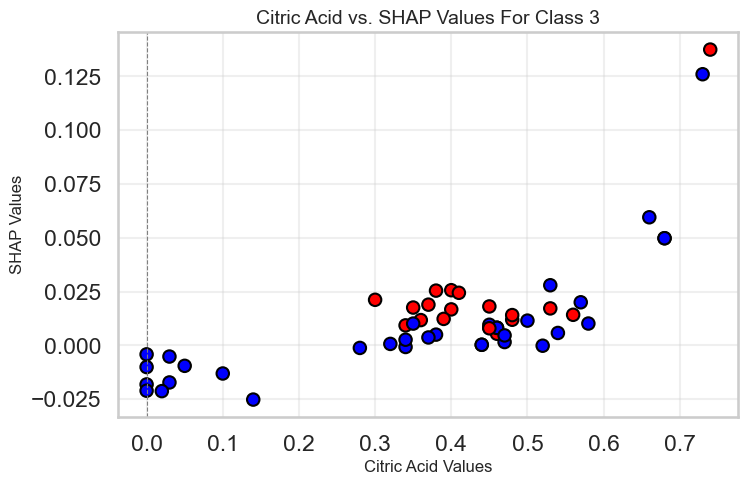

In [311]:
# Create scatter plot
plt.figure(figsize=(8, 5))
plt.scatter(X_f_test['citric acid'][y_f_test == 3], critic_acidity_class_3_shap_values, c=correctness, cmap="bwr", edgecolor="k", s=80)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.8)

# Add labels and title
plt.xlabel("Citric Acid Values", fontsize=12)
plt.ylabel("SHAP Values", fontsize=12)
plt.title("Citric Acid vs. SHAP Values For Class 3", fontsize=14)

plt.grid(alpha=0.3)
plt.show()

It's not very clear what happens around citric acid of 0.3 to 0.6,
let's see what the values there of other features:

In [317]:
falsness = correctness = np.array([cor[0] for cor in (y_f_pred[y_f_test.values == 3].values != 3)]).astype(bool)

In [318]:
falsness

array([ True,  True,  True, False,  True,  True,  True, False, False,
       False, False,  True, False,  True, False, False, False, False,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True, False,  True,  True,  True,  True,  True,  True, False,
        True,  True, False,  True,  True, False, False,  True,  True,
       False,  True,  True, False,  True,  True,  True,  True, False])

In [321]:
X_falsness_test = (X_f_test[y_f_test == 3])[falsness]

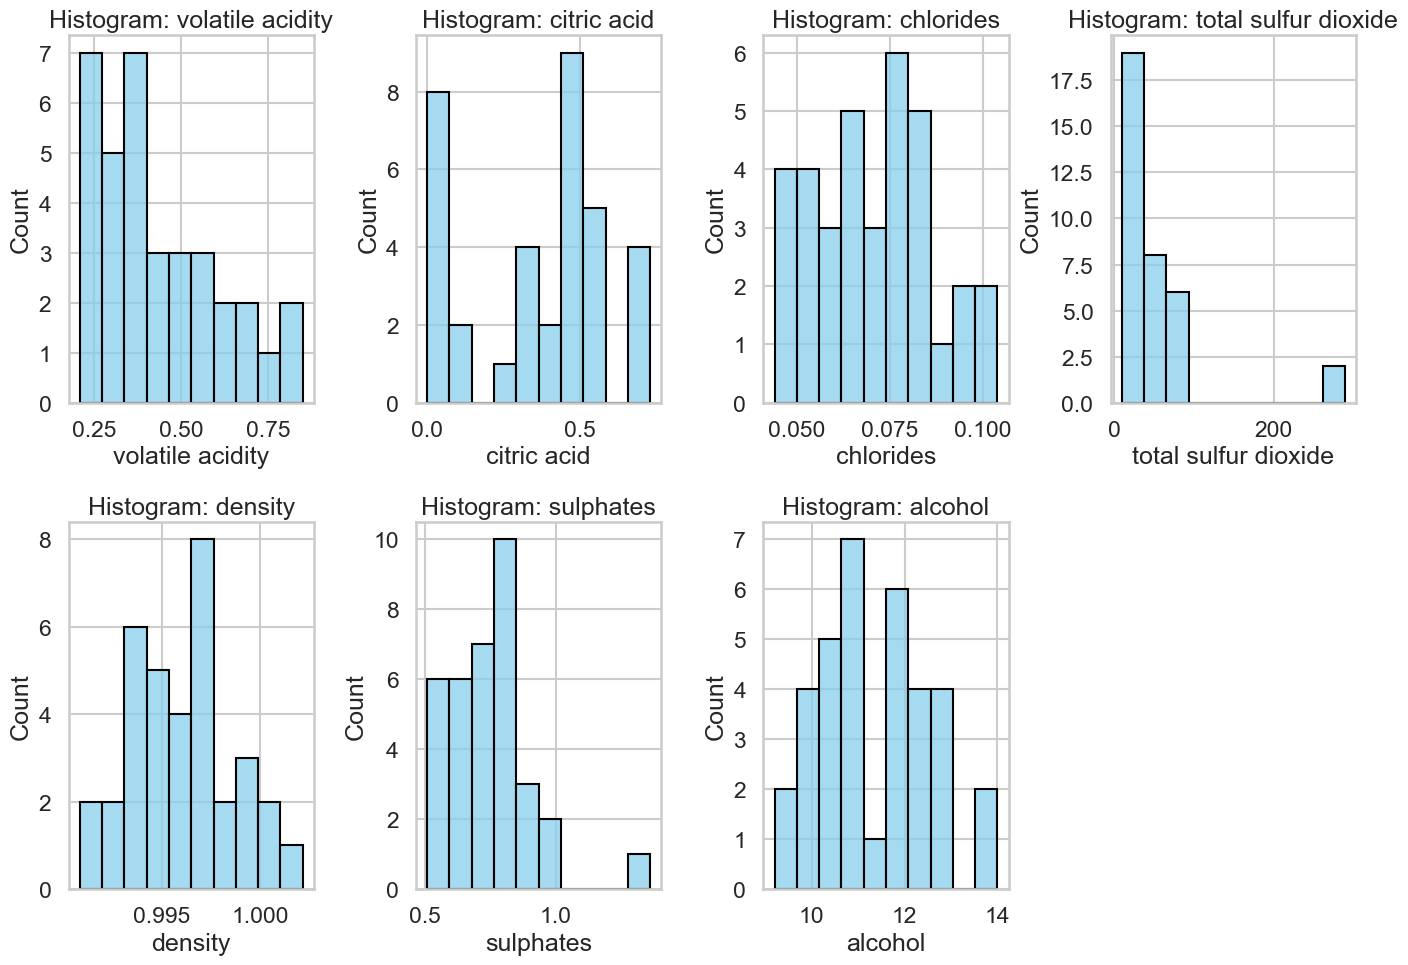

In [325]:
# Set up the matplotlib figure
plt.figure(figsize=(14, 10))

# Loop through each feature and plot the histogram with counts
for i, feature in enumerate(X_falsness_test.columns):
    plt.subplot(2, 4, i+1)  # Create a 2x4 grid for 8 features
    sns.histplot(X_falsness_test[feature], kde=False, stat='count', bins=10, color='skyblue', edgecolor='black')
    plt.title(f"Histogram: {feature}")
    plt.xlabel(feature)
    plt.ylabel("Count")

plt.tight_layout()
plt.show()

critic acidity should!!! help more with sepreate 1 from 2 (according to eda)

Let's force the model to give it more credit:

In [99]:
X_e_test.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol'],
      dtype='object')

In [132]:
cols = ['citric acid']
X_ee_test = X_e_test[cols]
X_ee_train = X_e_train[cols]
y_ee_train = y_e_train
y_ee_test = y_e_test

In [133]:
basic_model.fit(X_ee_train, y_ee_train)
y_ee_pred = round_results(basic_model.predict(X_ee_test))

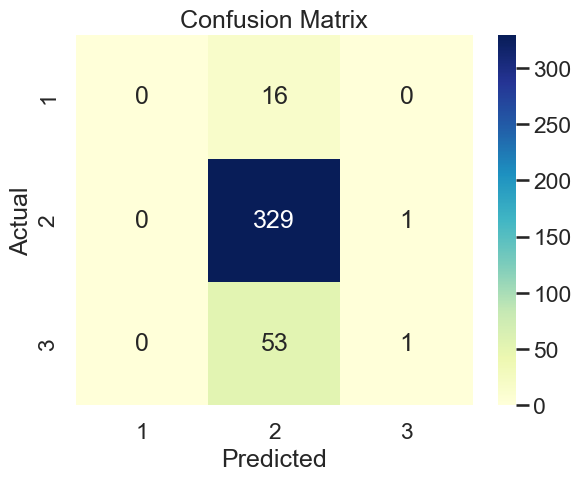

In [125]:
calculate_confusion_matrix(y_true=y_ee_test, y_pred=y_ee_pred)

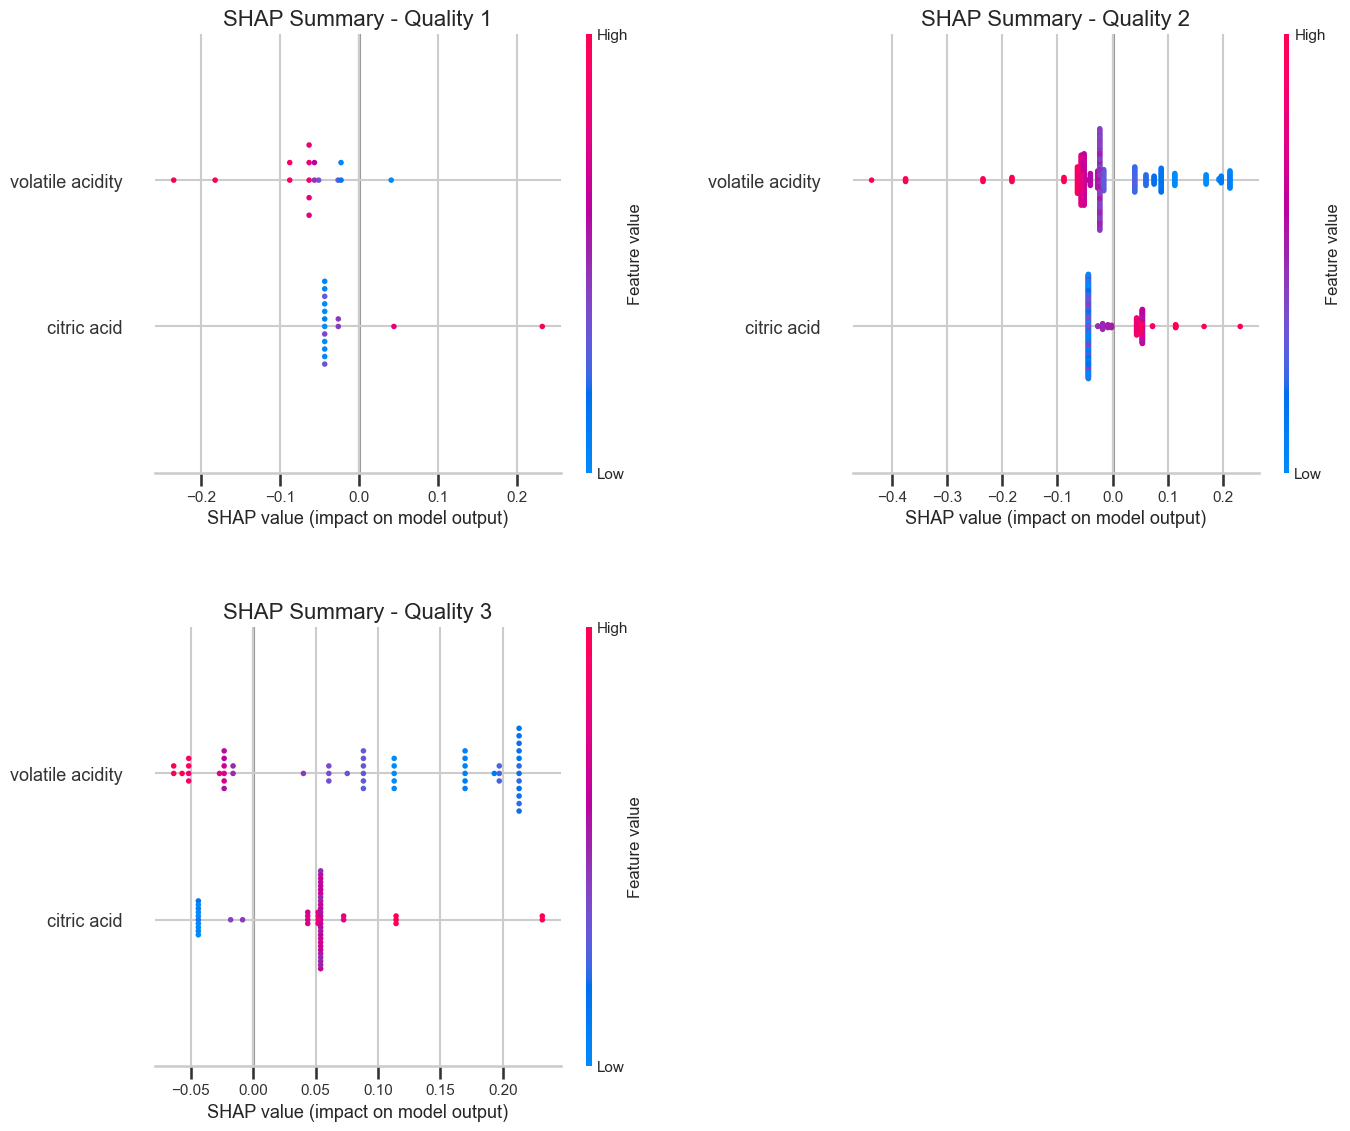

In [126]:
explainer = shap.TreeExplainer(basic_model)
shap_values_ee = explainer.shap_values(X_ee_test, y_ee_test)
plot_shap_values_by_classes(shap_values_ee, X_test=X_ee_test, y_test=y_ee_test, classes_numbers=[1,2,3])

In [134]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_ee_test, y_ee_test)

In [135]:
basic_model.fit(X_train_smote, y_train_smote)
y_ee_pred = round_results(basic_model.predict(X_ee_test))

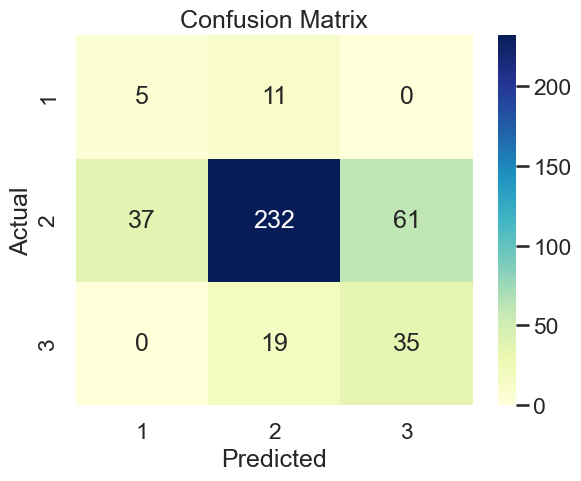

In [136]:
calculate_confusion_matrix(y_true=y_ee_test, y_pred=y_ee_pred)

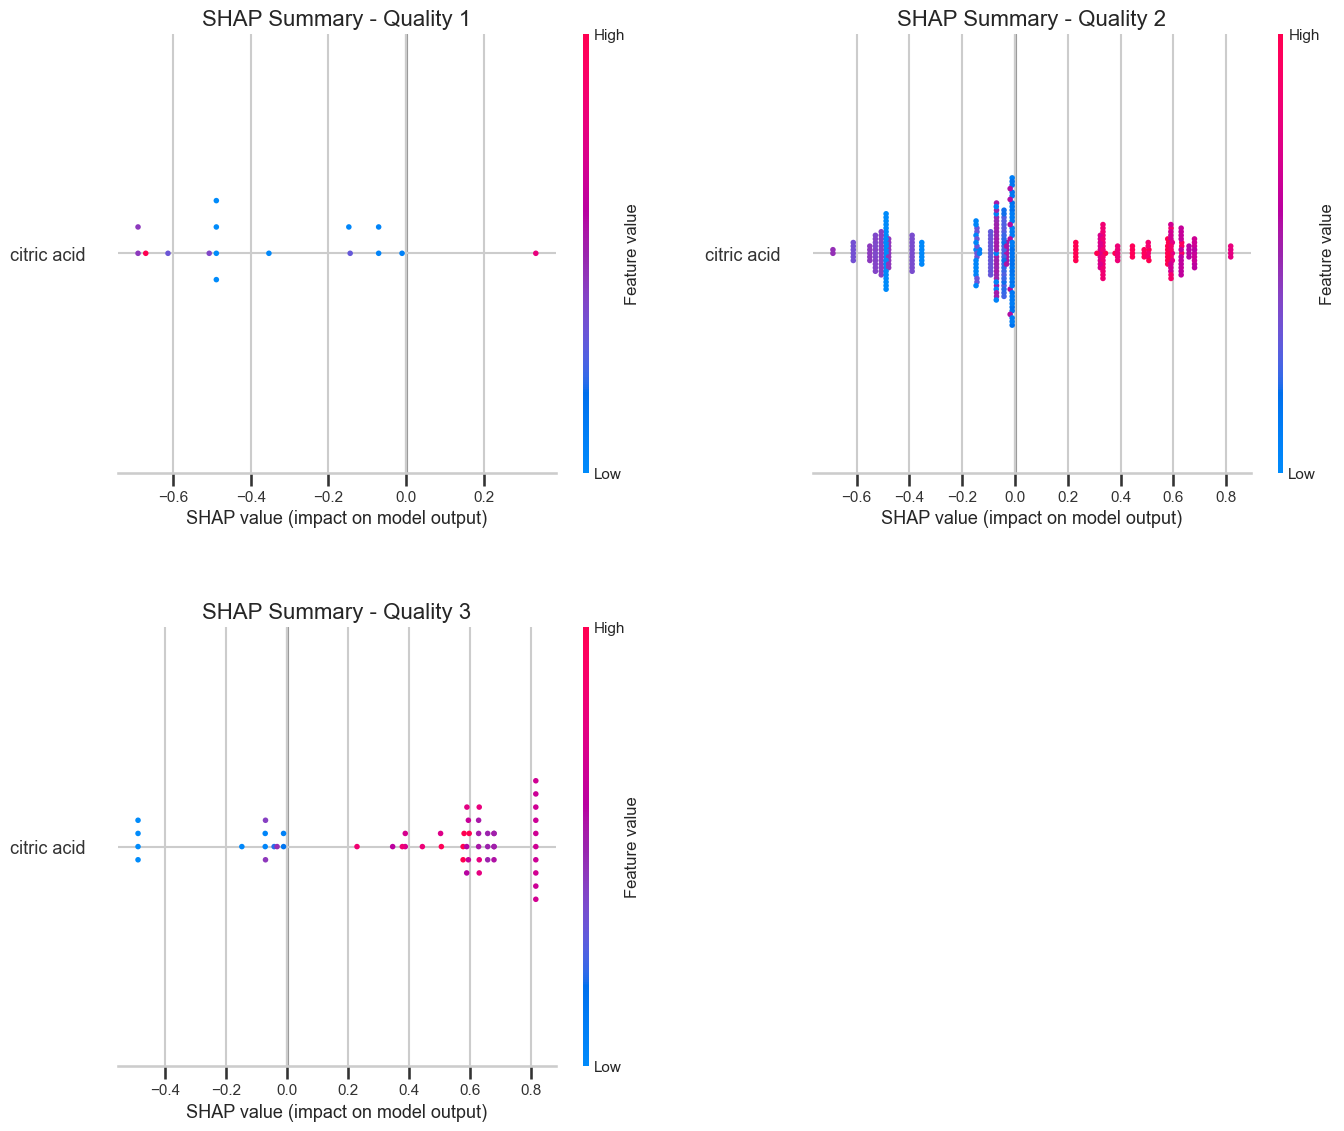

In [137]:
explainer = shap.TreeExplainer(basic_model)
shap_values_ee = explainer.shap_values(X_ee_test, y_ee_test)
plot_shap_values_by_classes(shap_values_ee, X_test=X_ee_test, y_test=y_ee_test, classes_numbers=[1,2,3])

#### feature selection

In [991]:
basic_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=30, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

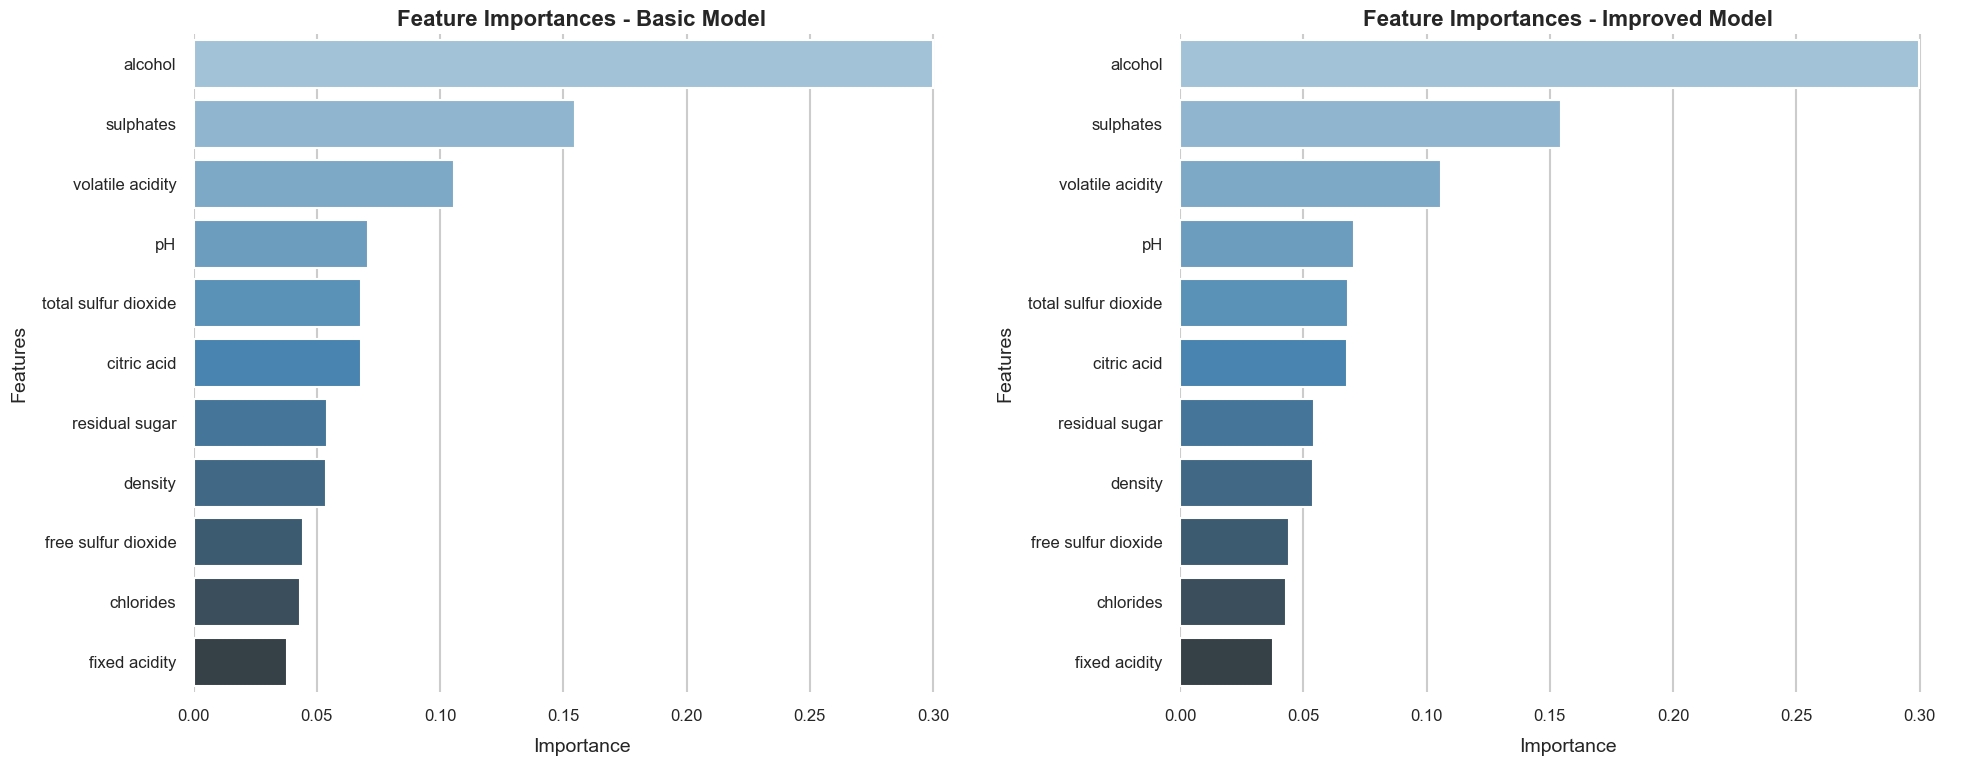

In [975]:
importances_df2 = pd.DataFrame({
    'Feature': X.columns,
    'Importance': basic_model.feature_importances_
}).sort_values('Importance', ascending=False)

importances_df1 = pd.DataFrame({
    'Feature': dfr.drop(columns=[target]).columns,
    'Importance': basic_model.feature_importances_
}).sort_values('Importance', ascending=False)

sns.set_style("whitegrid")
sns.set_context("talk")

fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=False)

sns.barplot(
    data=importances_df1,
    x='Importance',
    y='Feature',
    palette='Blues_d',
    ax=axes[0]
)
axes[0].set_title('Feature Importances - Basic Model', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Importance', fontsize=14, labelpad=10)
axes[0].set_ylabel('Features', fontsize=14, labelpad=10)
axes[0].tick_params(labelsize=12)
sns.despine(ax=axes[0], left=True, bottom=True)

sns.barplot(
    data=importances_df2,
    x='Importance',
    y='Feature',
    palette='Blues_d',
    ax=axes[1]
)
axes[1].set_title('Feature Importances - Improved Model', fontsize=16, fontweight='bold')
axes[1].set_xlabel('Importance', fontsize=14, labelpad=10)
axes[1].set_ylabel('Features', fontsize=14, labelpad=10)
axes[1].tick_params(labelsize=12)
sns.despine(ax=axes[1], left=True, bottom=True)

plt.tight_layout()

plt.show()


We can see that except of: alocohol, sulphates and volatile acidity, all feature has a very low important score.
Before remove those, let's have a look at the correlation matrix to gain more knowledge of them:

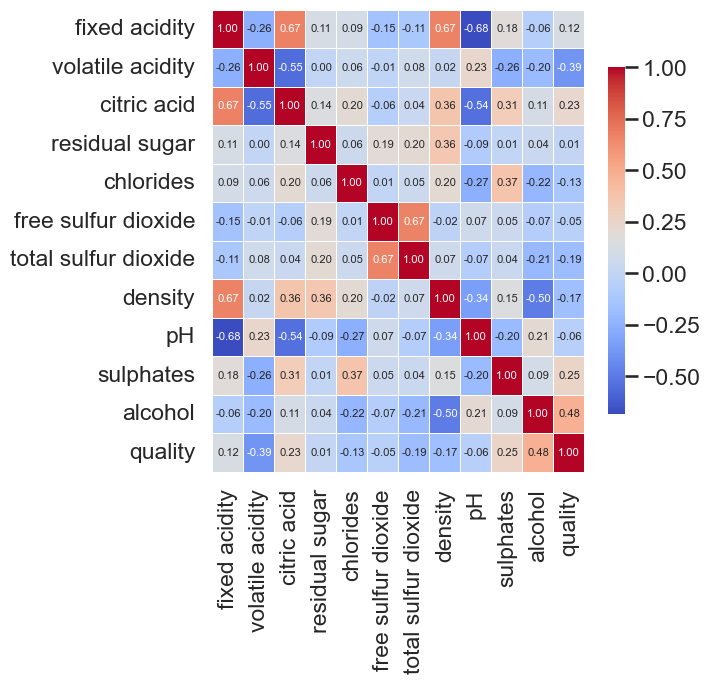

fixed acidity         fixed acidity           1.0
volatile acidity      volatile acidity        1.0
alcohol               alcohol                 1.0
sulphates             sulphates               1.0
pH                    pH                      1.0
density               density                 1.0
total sulfur dioxide  total sulfur dioxide    1.0
free sulfur dioxide   free sulfur dioxide     1.0
chlorides             chlorides               1.0
residual sugar        residual sugar          1.0
citric acid           citric acid             1.0
quality               quality                 1.0
dtype: float64


In [976]:
full_df = pd.concat([X, y], axis=1)

# Assuming X is your feature datafram
corr_matrix = full_df.corr()

# Plot the correlation matrix
plt.figure(figsize=(6, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, 
            annot_kws={'size': 8},  # Adjust annotation text size
            cbar_kws={'shrink': 0.75})  # Optionally adjust colorbar size
plt.show()

# Find highly correlated features (greater than 0.9 correlation)
threshold = 0.9
corr_pairs = corr_matrix.unstack().sort_values(ascending=False)
high_corr = corr_pairs[corr_pairs > threshold]
print(high_corr)

# Feature Engineering:

### Alcohol * Density

Based on the formula for density, the alcohol content in terms of mass can be calculated by multiplying the alcohol percentage by volume with the corresponding density. This calculation introduces a new feature, named alcohol_density, which may provide additional insights into the dataset.

In [731]:
X['alcohol density'] = X['alcohol'] * X['density']

## Total Acidity

Acidity, determined by the total sum of acids in a sample, is a key indicator of wine balance during winemaking. It is quantified as the sum of `fixed_acidity`, `volatile_acidity`, and `citric_acid`:

- **`fixed_acidity`**: Low-volatility organic acids like malic, lactic, tartaric, and citric acids, inherent to the sample's characteristics.
- **`volatile_acidity`**: Short-chain organic acids (e.g., formic, acetic, propionic, butyric acids) extractable via distillation.


In [732]:
X['total acidity'] = X['volatile acidity'] + X['fixed acidity'] + X['citric acid']

# experimenting with this feature
X['percent acidity'] = (X['volatile acidity'] / (X['fixed acidity']) + X['citric acid'])
print('Correlation with the target feature:')
print('total acidity', np.corrcoef(X['total acidity'], y)[0][1])
print('percent acidity', np.corrcoef(X['percent acidity'], y)[0][1])
print('volatile acidity', np.corrcoef(X['volatile acidity'], y)[0][1])
print('fixed acidity', np.corrcoef(X['fixed acidity'], y)[0][1])
print('citric acid', np.corrcoef(X['citric acid'], y)[0][1])

Correlation with the target feature:
total acidity 0.10375372825598383
percent acidity 0.19546266788359332
volatile acidity -0.39055778026400684
fixed acidity 0.1240516491132243
citric acid 0.2263725143180414


## Ideal ph Level

According to this [source](https://morewinemaking.com/articles/testing_wine_must), the ideal ph level for red wine should be around the 3.4 to 3.6 range. A `pH` above 3.6 indicates and unstable wine and will not have a long shelf life. pH under 3.4 generally indicates a wine that will be too sour. This may serve as a relevant indicator of what differentiated a good from a bad red wine.

In [733]:
X['ideal ph'] = 0
X.loc[(X['pH'] >= 3.4) & (X['pH'] <= 3.65), 'ideal ph'] = 1
print('Correlation with the target feature:')
print('ideal ph', np.corrcoef(X['ideal ph'], y)[0][1])
print('pH', np.corrcoef(X['pH'], y)[0][1])

Correlation with the target feature:
ideal ph -0.04809480006463261
pH -0.05773139120538216


## Acidity * ph

In [734]:
X['ph acidity'] = X['pH'] * X['percent acidity']
print('Correlation with the target feature:')
print('ph acidity', np.corrcoef(X['ph acidity'], y)[0][1])
print('pH', np.corrcoef(X['pH'], y)[0][1])
print('percent acidity', np.corrcoef(X['percent acidity'], y)[0][1])

Correlation with the target feature:
ph acidity 0.19678899392992685
pH -0.05773139120538216
percent acidity 0.19546266788359332


## Percent Free SO2

`sulfur_dioxide` is used in winemaking as a preservative to prevent oxidation and microbial spoilage. It exists in three forms; bisulfite (HSO3-), molecular SO2, and sulfite (SO32). The equilibrium is pH dependent with the predominate form at wine pH being bisulfite. Most of the rest is molecular and very little, if any, remains in sulfite form. These forms make up what is termed as `free_sulfur_dioxide`. `free_sulfur_dioxide` can be lost through volatilization or binding, thus management is important.


In [735]:
X['percent free sulfur'] = X['free sulfur dioxide'] / X['total sulfur dioxide']
print('Correlation with the target feature:')
print('percent free sulfur', np.corrcoef(X['percent free sulfur'], y)[0][1])
print('total sulfur dioxide', np.corrcoef(X['total sulfur dioxide'], y)[0][1])
print('free sulfur dioxide', np.corrcoef(X['free sulfur dioxide'], y)[0][1])

Correlation with the target feature:
percent free sulfur 0.1941133507473079
total sulfur dioxide -0.18510028892653774
free sulfur dioxide -0.05065605724427627


# Improved pipeline:

We continue to use the xgboost regressor, like in EX1. This time we specify parameters for the model:

1. The number of classes is 6
2. The objective of the model is softprob, returning the confidence level of the predictions.
3. For evaluation metric, Mlogloss is perfect, Mlogloss measures the dissimilarity between the predicted class probabilities and the actual class labels, with lower values indicating better performance.

Then, we search for the best parameters, this includes:
1. max_depth - Controls the complexity of the model: deeper trees can capture more complex patterns but may lead to overfitting.
2. n_estimatos - Determines the ensemble size: more trees generally improve performance but increase computation time and risk of overfitting.
3. learning_rate - Lower values make the training process slower and more stable, while higher values speed up training but might miss optimal solutions.

In [ ]:
# TODO: Update requirments.txt, WATCHOUT THOUGH! he said he will deduct points if we put libraries that are common, he said put only the less common libraries
# TODO: Update the metrics:

# Results

### Key Takeaways: Pipeline Improvement

1. **Overall Performance:**
   - **Basic Pipeline:** Lower metrics across the board, with macro-average scores:
     - Precision: ~0.58
     - Recall: ~0.39
     - F1-score: ~0.42
   - **Improved Pipeline:** Significantly higher metrics:
     - Precision: ~0.85
     - Recall: ~0.85
     - F1-score: ~0.85

2. **Class-Specific Improvements:**
   - **Class 3:**
     - Basic Pipeline: Near-zero performance for all metrics.
     - Improved Pipeline: Precision (0.96), Recall (0.99), F1-score (0.98), showing near-perfect results.
   - **Class 8:**
     - Basic Pipeline: Precision (1.0), but low Recall (0.20), leading to a poor F1-score.
     - Improved Pipeline: Well-balanced performance with Precision (0.98), Recall (1.00), and F1-score (0.99).
   - Significant improvements are also observed in **Classes 4** and **7**, with much higher recall and F1-scores.

3. **Accuracy:**
   - Basic Pipeline: 0.64
   - Improved Pipeline: 0.85 (substantial improvement in overall correctness). A 33% improvement

4. **Metric Balance:**
   - **Basic Pipeline:** Noticeable imbalance between precision and recall, resulting in poor F1-scores.
   - **Improved Pipeline:** Better alignment between precision and recall, yielding consistently higher F1-scores.

5. **Common Classes:**
    In the improved pipeline, we can see the results for the common class are a bit wierd, for class 5 we did improve the results. For class 6, the precision went up, but the accuracy and f1-score went down a little bit, this happend because we used SMOTE. It's normal to see a trade-off when you apply SMOTE or any method aimed at boosting minority classes. By giving extra attention (and synthetic samples) to the underrepresented classes, the model may shift some of its decision boundary away from the majority classes.

Overall, adding custom features, balancing the minority classes, and optimizing our hyperparameters, improved the model significantly

# Feature Importance:

In [874]:
importances_df2 = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_model.feature_importances_
}).sort_values('Importance', ascending=False)

importances_df1 = pd.DataFrame({
    'Feature': dfr.drop(columns=[target]).columns,
    'Importance': basic_model.feature_importances_
}).sort_values('Importance', ascending=False)

sns.set_style("whitegrid")
sns.set_context("talk")

fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=False)

sns.barplot(
    data=importances_df1,
    x='Importance',
    y='Feature',
    palette='Blues_d',
    ax=axes[0]
)
axes[0].set_title('Feature Importances - Basic Model', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Importance', fontsize=14, labelpad=10)
axes[0].set_ylabel('Features', fontsize=14, labelpad=10)
axes[0].tick_params(labelsize=12)
sns.despine(ax=axes[0], left=True, bottom=True)

sns.barplot(
    data=importances_df2,
    x='Importance',
    y='Feature',
    palette='Blues_d',
    ax=axes[1]
)
axes[1].set_title('Feature Importances - Improved Model', fontsize=16, fontweight='bold')
axes[1].set_xlabel('Importance', fontsize=14, labelpad=10)
axes[1].set_ylabel('Features', fontsize=14, labelpad=10)
axes[1].tick_params(labelsize=12)
sns.despine(ax=axes[1], left=True, bottom=True)

plt.tight_layout()

plt.show()


NotFittedError: need to call fit or load_model beforehand

**Key Takeaways from the Comparison of Basic vs. Improved XGBRegressor Models**

1. **Alcohol Dominates Both Models**
   - In both the basic and improved models, **alcohol** remains a top predictor of wine quality, reflecting its strong role in influencing taste and overall wine profile.

2. **Newly Introduced Features in the Improved Model**
   - The improved model includes features such as **alcohol density** and **ideal pH**, which appear highly influential. This suggests that the feature engineering we did can yield more informative insights for the model.

3. **Shift in Importance of Sulphates**
   - In the basic model, **sulphates** ranks second, whereas in the improved model it falls behind several other features, including chlorides and total sulfur dioxide. This indicates that with additional or more nuanced features (e.g., alcohol density, ideal pH), the model’s reliance on sulphates alone for quality prediction decreases. This might also have happened because we resampled the dataset.

4. **Importance of Sulfur Compounds**
   - **Total sulfur dioxide** and **free sulfur dioxide** appear in the mid-to-high range of importance in both models, underlining sulfur compounds’ role in wine preservation and flavor profile.

5. **Acidity Factors Remain Relevant**
   - Features such as **pH**, **ideal pH**, and **volatile acidity** consistently show up in the higher tier of feature importances. Reinforcing the significance of acidity balance in wine quality.

6. **Feature Engineering’s Positive Impact**
   - The improved model distributes feature importance more evenly across a wider range of variables. This may point to better predictive performance, as the model identifies multiple complementary factors (rather than relying heavily on just one or two).

Overall, these plots highlight how **feature engineering** and **additional variables** can reveal new relationships (like “alcohol density” and “ideal pH”) and shift the model’s reliance toward a richer set of predictors, leading to potentially more robust wine quality predictions.
